# 2. Model Building and Evaluation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)'

/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)


## Imports

In [8]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import cv2 as cv
from utils import *
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost
import joblib
import re

## I. Load Training Data

In [6]:
data_path = os.path.join(cwd,'standardized_data/Training')

X = []
y = []

for label in os.listdir(data_path):
    for image in os.listdir(os.path.join(data_path,label)):
        image_path = os.path.join(data_path,label,image)
        load_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        # flatten_image = load_image.flatten()
        X.append(load_image)
        y.append(label)


# Convert to Numpy Array
X = np.array(X)
y = np.array(y)
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

print(X.shape)
print(y.shape)

print(X[0])
print(y[0])

(5712, 512, 512)
(5712,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0


## II. Base Model (most common class classifier)

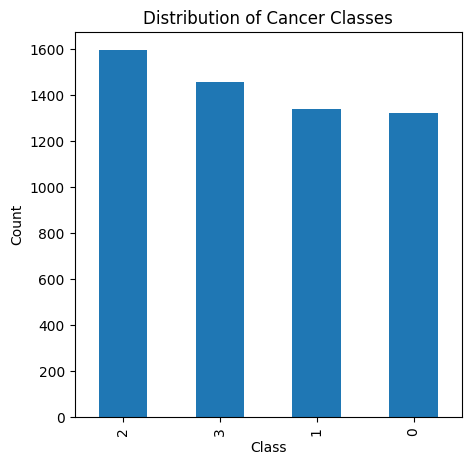

['glioma' 'meningioma' 'notumor' 'pituitary']


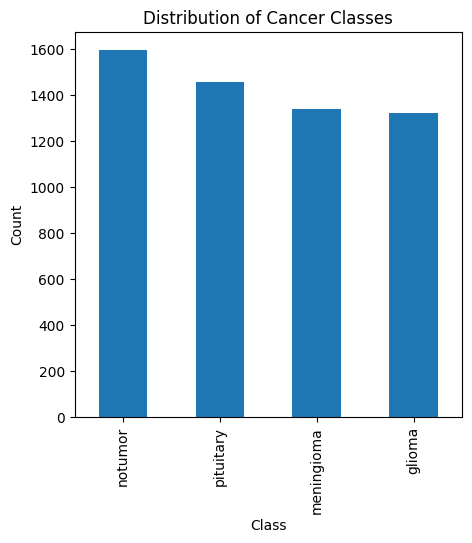

Most Common Label: 2
(5712,)
(5712,)


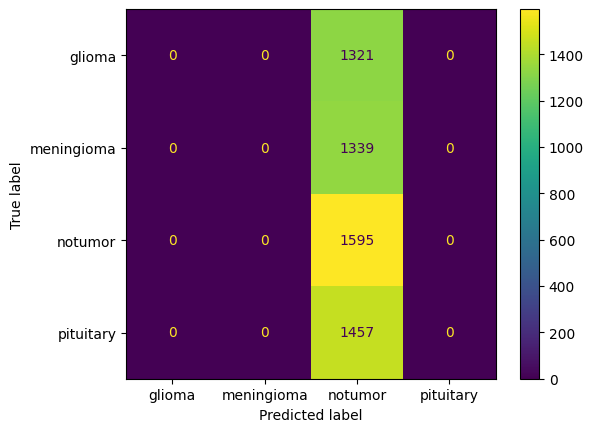

================== TRAINING METRICS ===================
Accuracy Score: 0.27923669467787116
Macro Precision: 0.06980917366946779
Macro Recall: 0.25
Macro F1: 0.10914191870808813
Micro Precision: 0.27923669467787116
Micro Recall: 0.27923669467787116
Micro F1: 0.27923669467787116


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
plt.figure(figsize=(5,5))
y_train_series = pd.Series(y)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()
print(le.classes_)
y_transformed = le.inverse_transform(y)

plt.figure(figsize=(5,5))
y_train_series = pd.Series(y_transformed)
y_train_series.value_counts().plot(kind='bar')
plt.title('Distribution of Cancer Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


# Generate Model Statistics
most_common_label = stats.mode(y)[0]
print("Most Common Label: " + str(most_common_label))
y_predict = np.ones((y.shape)) * most_common_label
print(y_predict.shape)
print(y.shape)

# Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.show()

accuracy_score = metrics.accuracy_score(y, y_predict)
macro_precision = metrics.precision_score(y,y_predict,average ='macro')
macro_recall = metrics.recall_score(y,y_predict,average='macro')
macro_f1 = metrics.f1_score(y,y_predict,average='macro')
micro_precision = metrics.precision_score(y,y_predict,average='micro')
micro_recall = metrics.recall_score(y,y_predict,average='micro')
micro_f1 = metrics.f1_score(y,y_predict,average='micro')

print("================== TRAINING METRICS ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

## III. Extract Features (Difference of Gaussians, Determinant of Hessian, Complex Feature)

In [37]:
aligned_train_features = pd.read_csv('aligned_training_features.csv')

In [38]:
aligned_train_features, dims, enc = clean_df(
    df=aligned_train_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

In [48]:
parsed_aligned_train_features  = parse_aligned_features(aligned_train_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])
parsed_aligned_train_features

{'filepath': array([['/Training/glioma/Tr-glTr_0000.jpg'],
        ['/Training/glioma/Tr-glTr_0001.jpg'],
        ['/Training/glioma/Tr-glTr_0002.jpg'],
        ...,
        ['/Training/pituitary/Tr-pi_1454.jpg'],
        ['/Training/pituitary/Tr-pi_1455.jpg'],
        ['/Training/pituitary/Tr-pi_1456.jpg']], dtype=object),
 'target': array([0, 0, 0, ..., 3, 3, 3], dtype=int32),
 'feat_canny': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'feat_vec': array([[-0.12438965,  0.39355469,  0.14697266, ..., -0.11523438,
          0.35449219, -1.0390625 ],
        [ 0.67773438,  0.70361328,  0.0871582 , ..., -0.62744141,
          0.73242188, -1.9765625 ],
        [ 0.85253906, -0.06665039, -0.0614624 , ...,  0.05441284,
          0.55273438, -0.90039062],
        ...,
        [ 0.26123047,  0.95556641,  0.40625   , ..., -0.24206543,
          0.94335938, -1.70214844],
        [ 0.43945312,  0

## IV. Shuffle Data

In [52]:
np.random.seed(281)

# Create a list of indexes that is the length of the number of training examples
indices = [i for i in range(0,X.shape[0])]
shuffle_indices = np.random.permutation(indices)

# Reorder X and Y based on the shuffled indices
# X = X[shuffle_indices]
# y = y[shuffle_indices]

X_dog_features = parsed_aligned_train_features['feat_dog'][shuffle_indices]
X_doh_features = parsed_aligned_train_features['feat_doh'][shuffle_indices]
X_complex_features = parsed_aligned_train_features['feat_vec'][shuffle_indices]

y_train = parsed_aligned_train_features['target'][shuffle_indices]

In [93]:
print(X_dog_features.shape)
print(X_dog_features.shape)
print(X_complex_features.shape)
print(y_train.shape)

(5712, 14)
(5712, 14)
(5712, 768)
(5712,)


## V. Model Training

In [56]:
features = {'dog':X_dog_features,
            'doh':X_doh_features,
            'complex': X_complex_features,
            'dog_doh': np.concatenate((X_dog_features, X_doh_features), axis=1),
            'doh_complex': np.concatenate((X_doh_features, X_complex_features), axis=1),
            'dog_complex': np.concatenate((X_dog_features, X_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_dog_features, X_doh_features, X_complex_features), axis=1)
            }

In [57]:
all_results = pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1',
                                      'micro_precision', 'micro_recall', 'micro_f1', 'training_time'])

### Logistic Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits


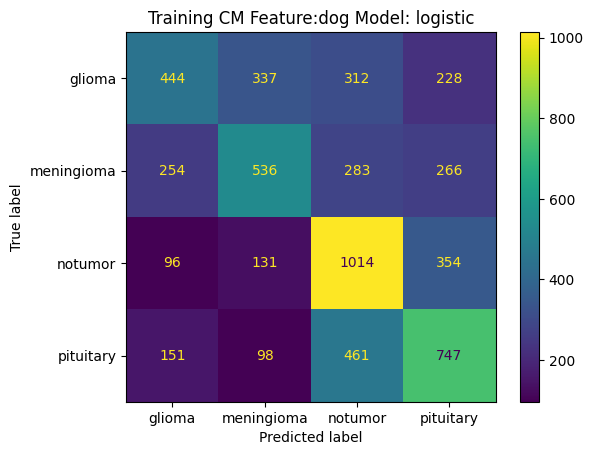

(5712, 4)


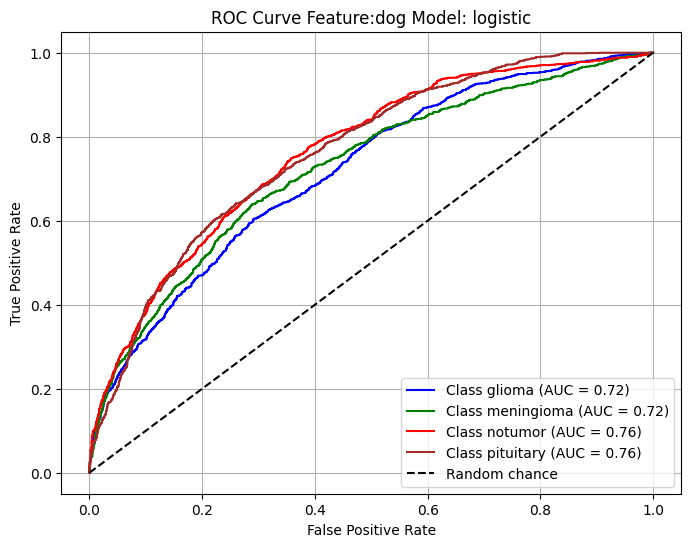

Fitting 5 folds for each of 4 candidates, totalling 20 fits


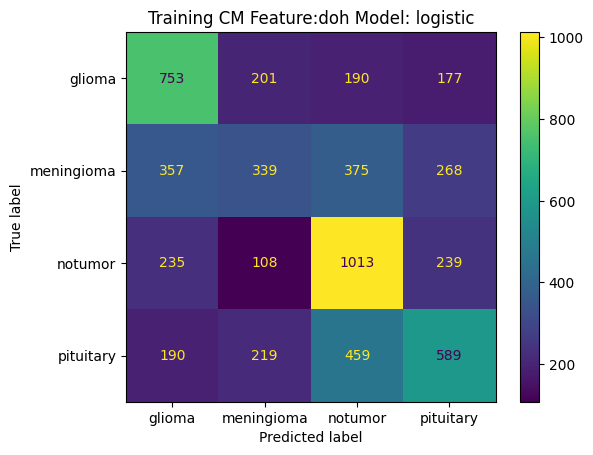

(5712, 4)


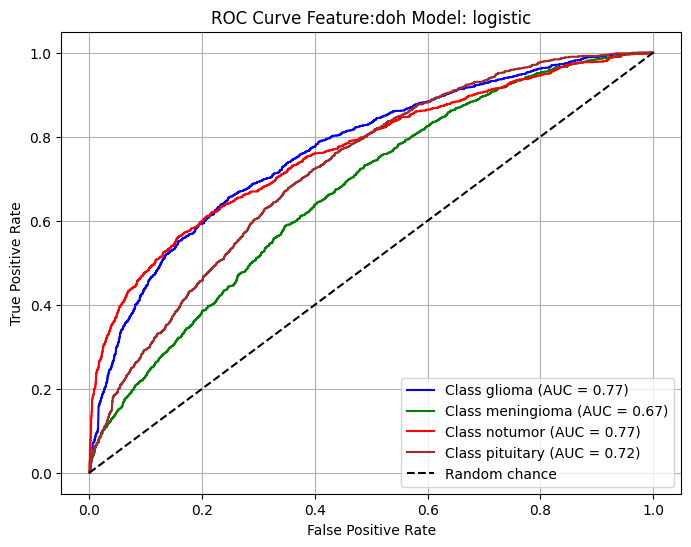

Fitting 5 folds for each of 4 candidates, totalling 20 fits


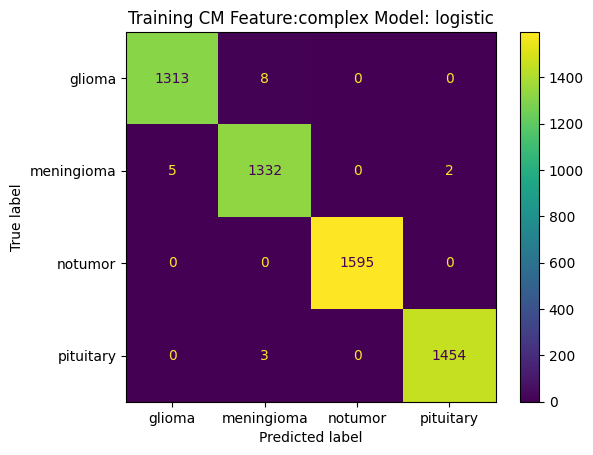

(5712, 4)


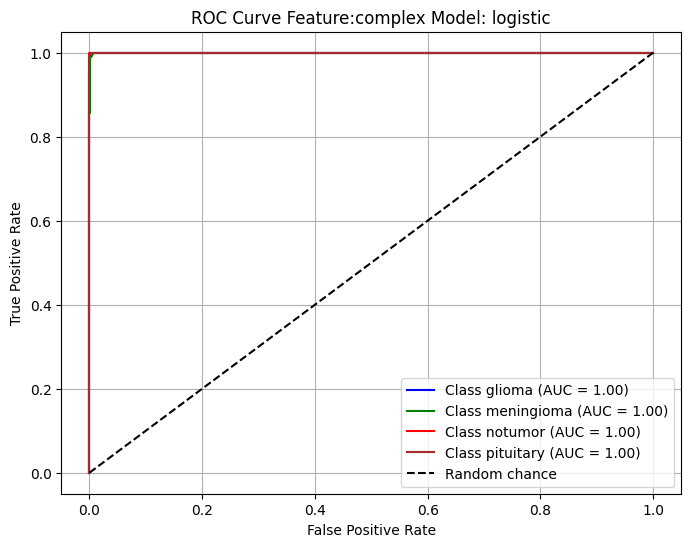

Fitting 5 folds for each of 4 candidates, totalling 20 fits


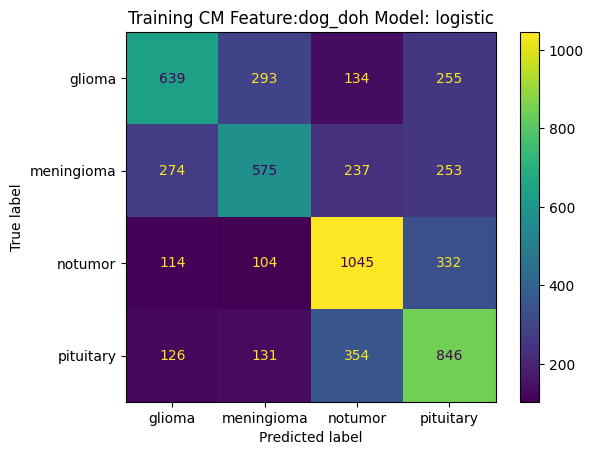

(5712, 4)


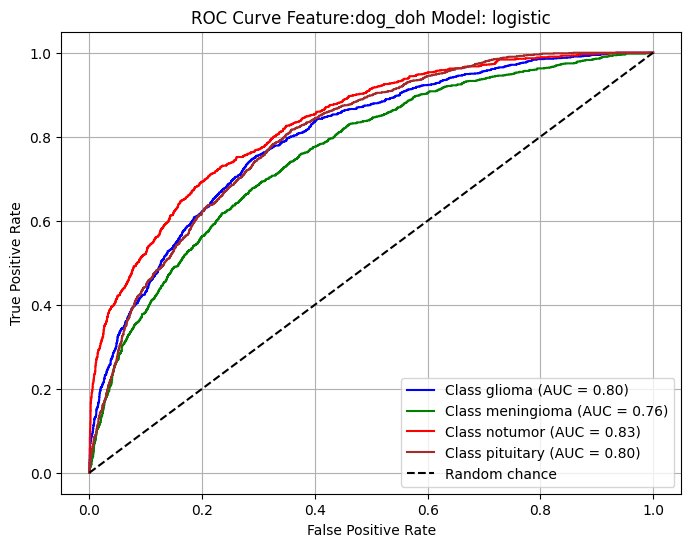

Fitting 5 folds for each of 4 candidates, totalling 20 fits


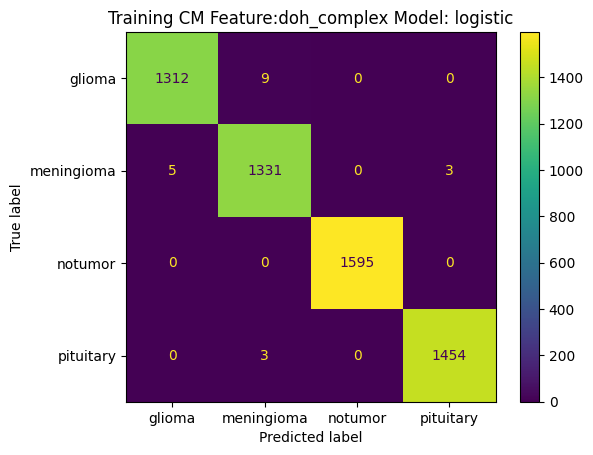

(5712, 4)


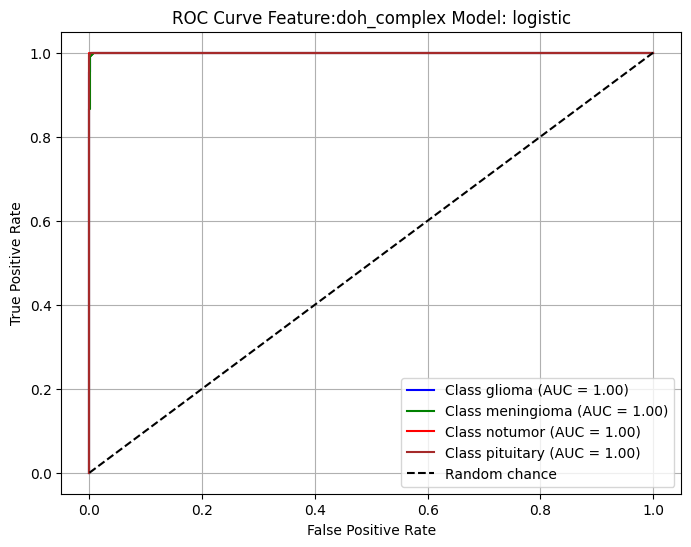

Fitting 5 folds for each of 4 candidates, totalling 20 fits


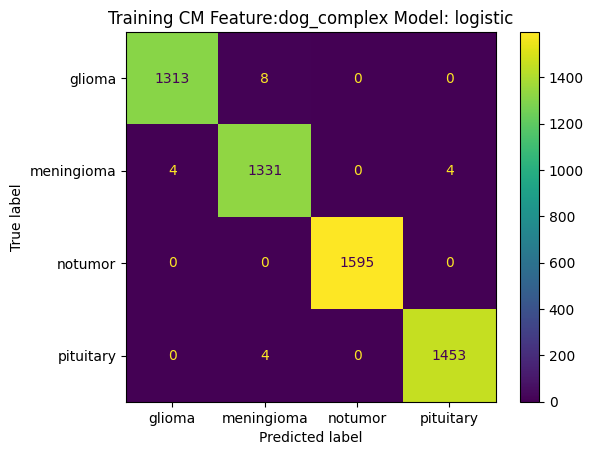

(5712, 4)


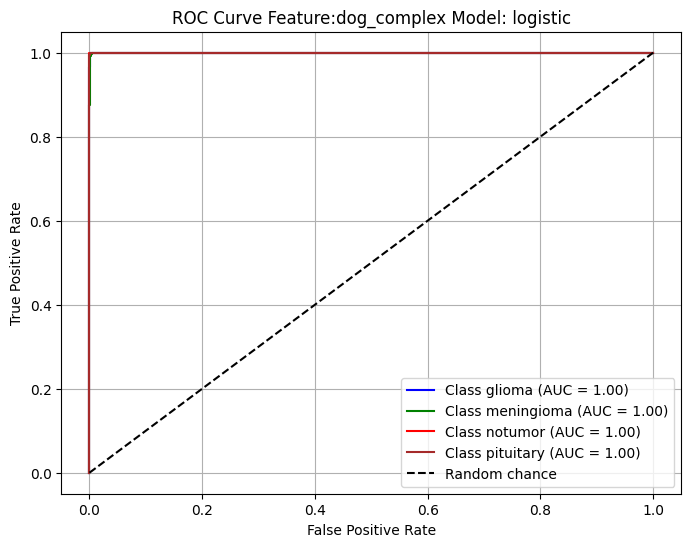

Fitting 5 folds for each of 4 candidates, totalling 20 fits


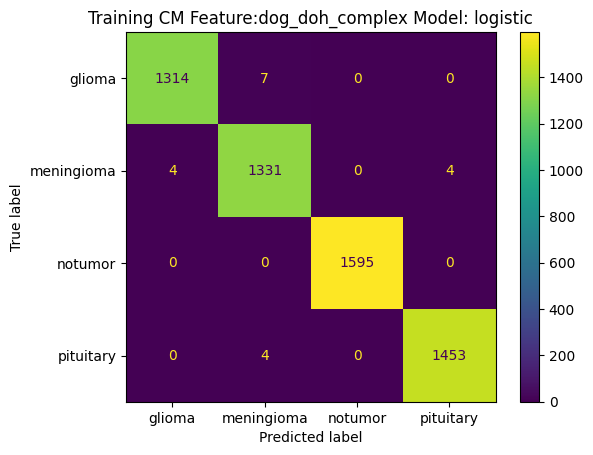

(5712, 4)


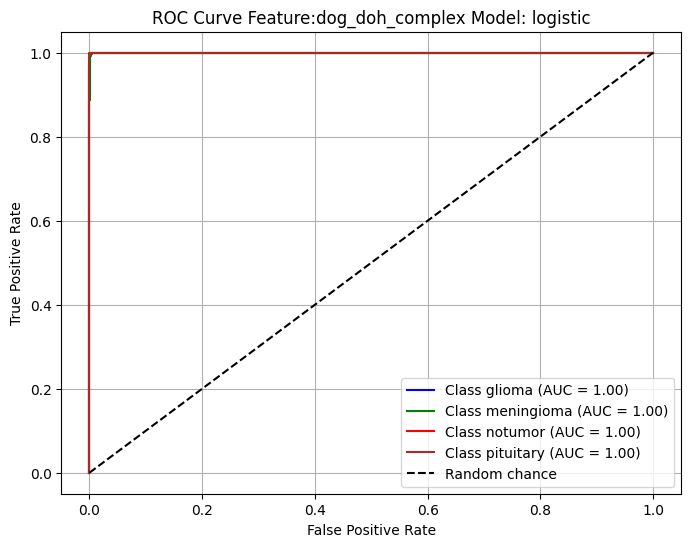

           feature model_type  accuracy_score  macro_precision  macro_recall  \
0              dog   logistic        0.479867         0.478606      0.471210   
1              doh   logistic        0.471639         0.460386      0.465640   
2          complex   logistic        0.996849         0.996661      0.996664   
3          dog_doh   logistic        0.543592         0.541922      0.537242   
4      doh_complex   logistic        0.996499         0.996302      0.996288   
5      dog_complex   logistic        0.996499         0.996321      0.996306   
6  dog_doh_complex   logistic        0.996674         0.996506      0.996495   

   macro_f1  micro_precision  micro_recall  micro_f1  training_time  
0  0.468475         0.479867      0.479867  0.479867       5.309745  
1  0.455994         0.471639      0.471639  0.471639      13.400570  
2  0.996662         0.996849      0.996849  0.996849     359.831393  
3  0.536734         0.543592      0.543592  0.543592      38.301736  
4  0.9962

In [60]:
logistic_models = {}
for feature in features.keys():
    logistic_model, results = train_model(features[feature], y_train, classes=le.classes_, model_type='logistic', feature=feature)
    logistic_models[feature] = logistic_model
    all_results.loc[len(all_results)] = results
print(all_results)

In [61]:
logistic_models

{'dog': LogisticRegression(max_iter=1000, solver='newton-cg'),
 'doh': LogisticRegression(max_iter=1000, solver='newton-cg'),
 'complex': LogisticRegression(max_iter=1000, solver='newton-cg'),
 'dog_doh': LogisticRegression(max_iter=1000),
 'doh_complex': LogisticRegression(max_iter=1000, solver='newton-cg'),
 'dog_complex': LogisticRegression(max_iter=1000, solver='newton-cg'),
 'dog_doh_complex': LogisticRegression(max_iter=1000, solver='newton-cg')}

In [97]:
save_models(logistic_models, 'logistic')

saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog to path=models/logistic_dog.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=doh to path=models/logistic_doh.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=complex to path=models/logistic_complex.joblib
saved model=LogisticRegression(max_iter=1000) for feature=dog_doh to path=models/logistic_dog_doh.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=doh_complex to path=models/logistic_doh_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog_complex to path=models/logistic_dog_complex.joblib
saved model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog_doh_complex to path=models/logistic_dog_doh_complex.joblib


### Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits


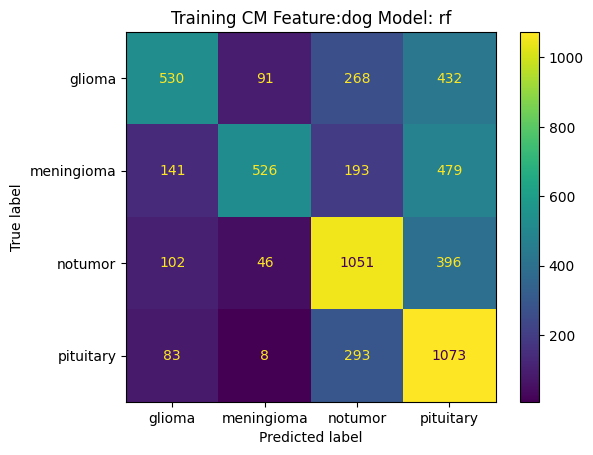

(5712, 4)


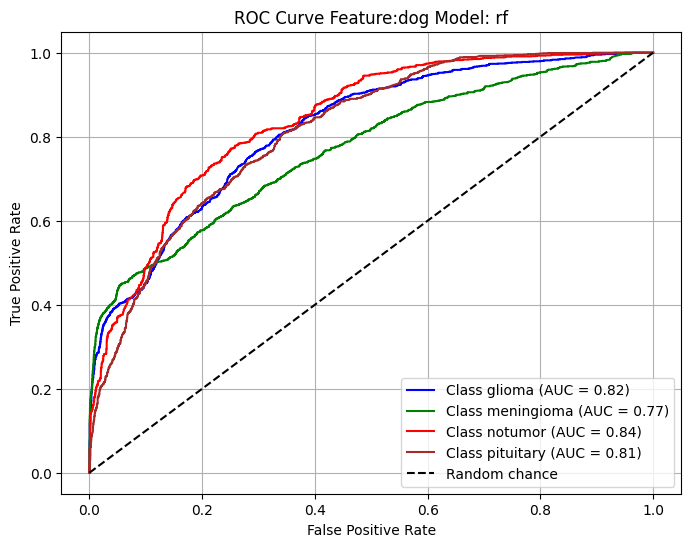

Fitting 5 folds for each of 24 candidates, totalling 120 fits


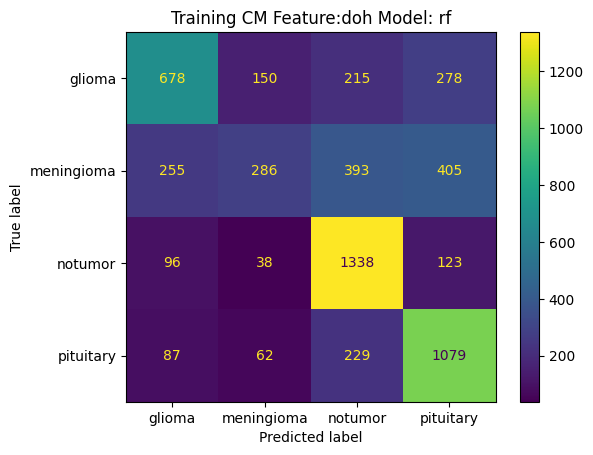

(5712, 4)


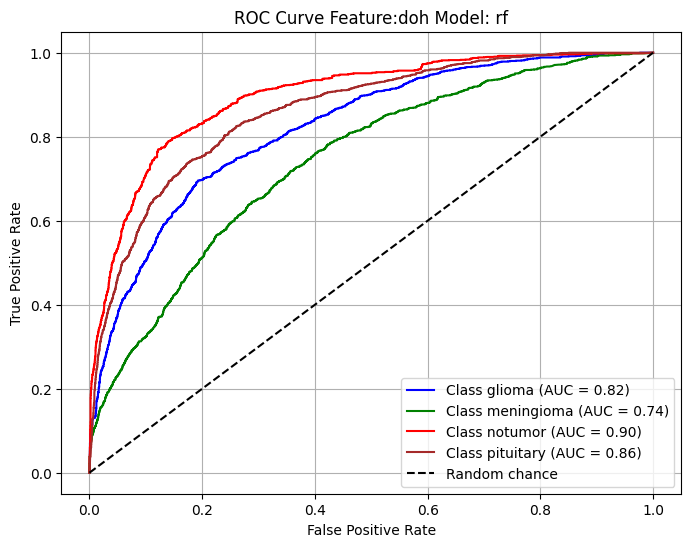

Fitting 5 folds for each of 24 candidates, totalling 120 fits


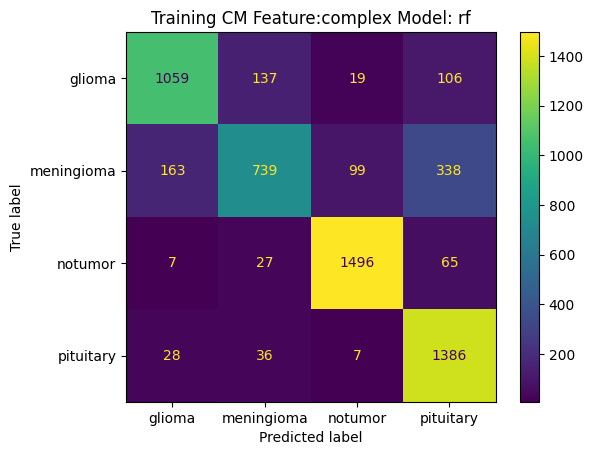

(5712, 4)


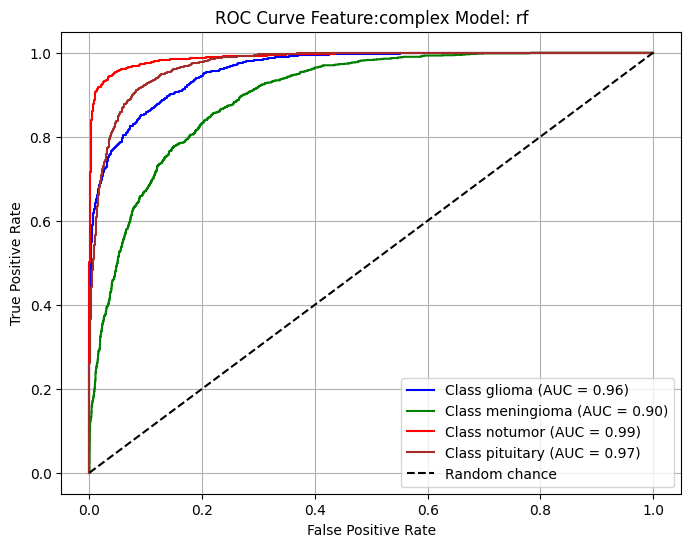

Fitting 5 folds for each of 24 candidates, totalling 120 fits


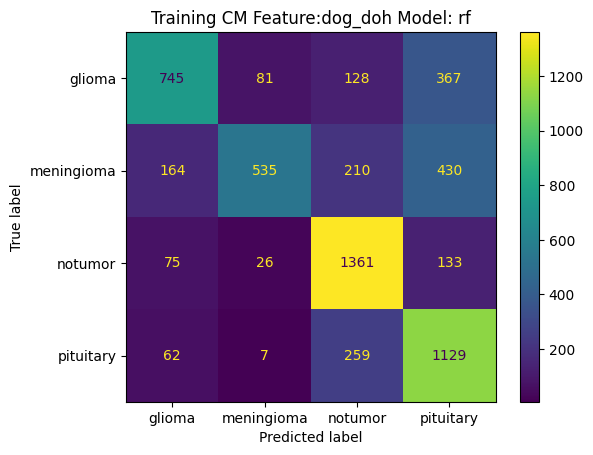

(5712, 4)


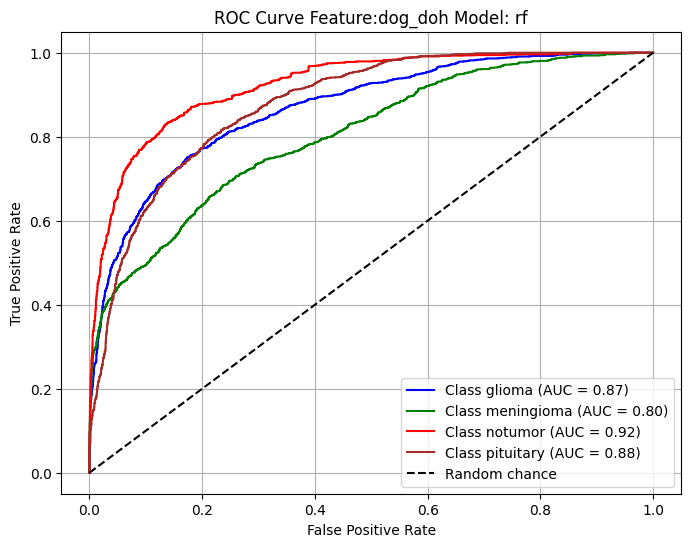

Fitting 5 folds for each of 24 candidates, totalling 120 fits


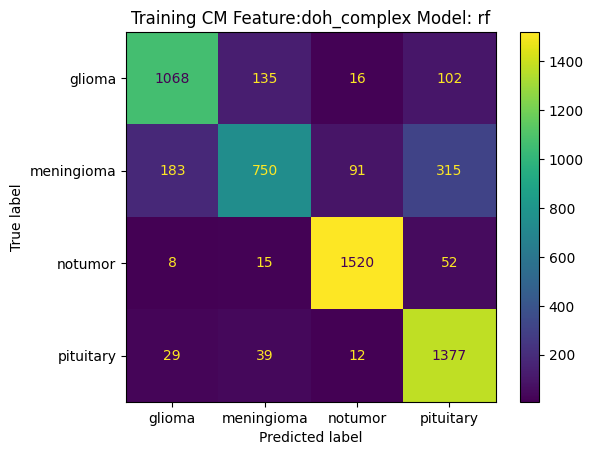

(5712, 4)


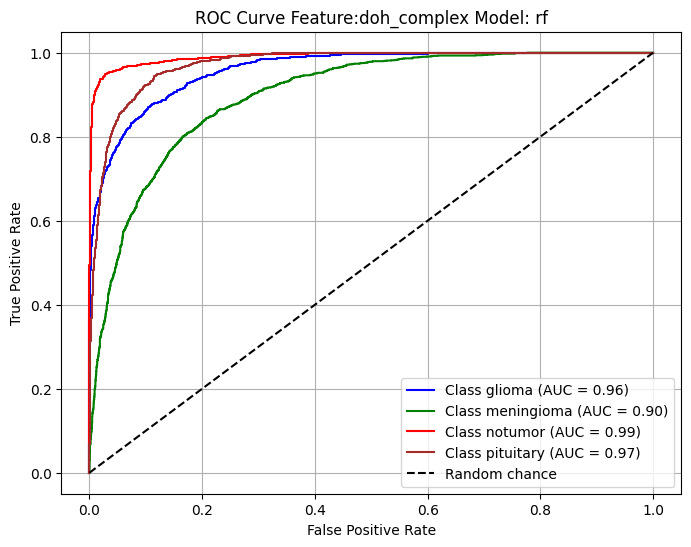

Fitting 5 folds for each of 24 candidates, totalling 120 fits


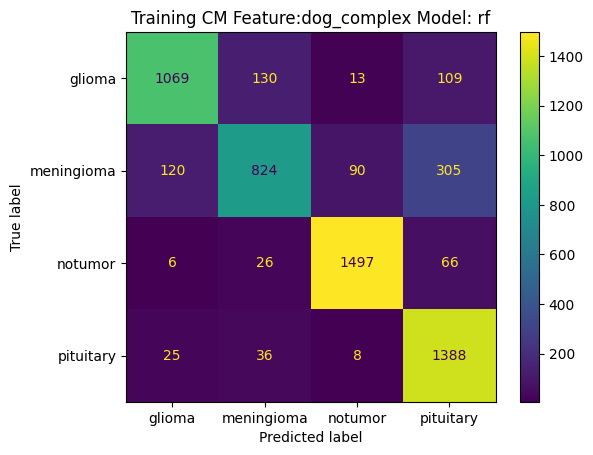

(5712, 4)


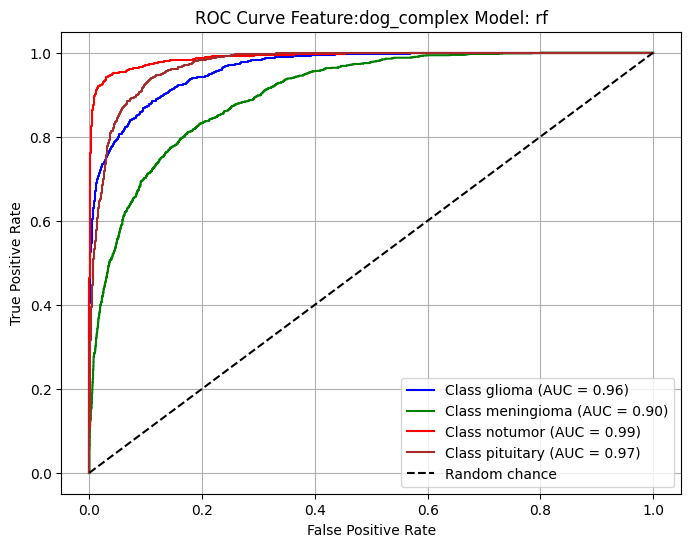

Fitting 5 folds for each of 24 candidates, totalling 120 fits


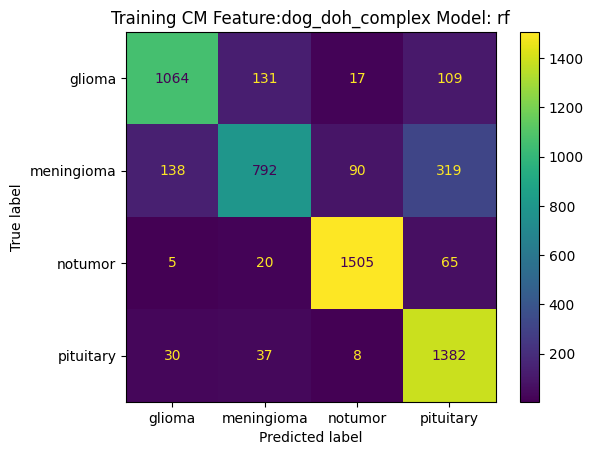

(5712, 4)


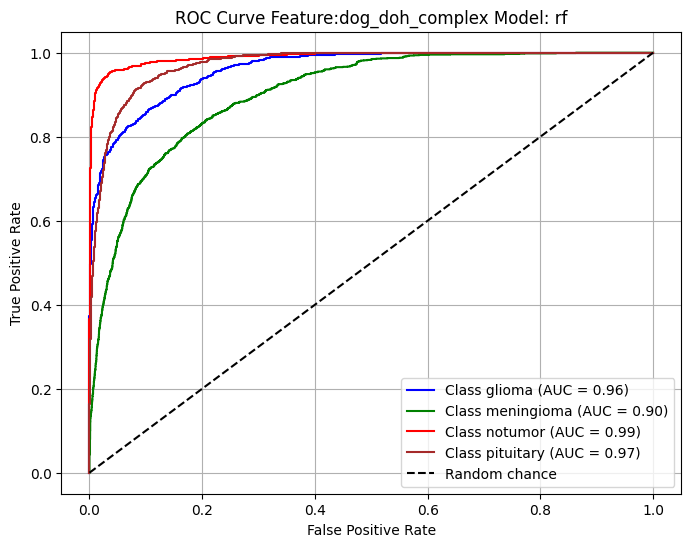

            feature model_type  accuracy_score  macro_precision  macro_recall  \
0               dog   logistic        0.479867         0.478606      0.471210   
1               doh   logistic        0.471639         0.460386      0.465640   
2           complex   logistic        0.996849         0.996661      0.996664   
3           dog_doh   logistic        0.543592         0.541922      0.537242   
4       doh_complex   logistic        0.996499         0.996302      0.996288   
5       dog_complex   logistic        0.996499         0.996321      0.996306   
6   dog_doh_complex   logistic        0.996674         0.996506      0.996495   
7               dog         rf        0.556723         0.609044      0.547355   
8               doh         rf        0.591912         0.582174      0.576569   
9           complex         rf        0.819328         0.820944      0.810693   
10          dog_doh         rf        0.660014         0.695001      0.647923   
11      doh_complex         

In [64]:
rf_models = {}
for feature in features.keys():
    rf_model, results = train_model(features[feature], y_train, classes=le.classes_, model_type='rf', feature=feature)
    rf_models[feature] = rf_model
    all_results.loc[len(all_results)] = results

print(all_results)

In [65]:
rf_models

{'dog': RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=110),
 'doh': RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=80),
 'complex': RandomForestClassifier(max_depth=4, n_estimators=110),
 'dog_doh': RandomForestClassifier(max_depth=4, n_estimators=90),
 'doh_complex': RandomForestClassifier(max_depth=4, n_estimators=90),
 'dog_complex': RandomForestClassifier(max_depth=4, n_estimators=110),
 'dog_doh_complex': RandomForestClassifier(max_depth=4)}

In [98]:
save_models(rf_models, 'rf')

saved model=RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=110) for feature=dog to path=models/rf_dog.joblib
saved model=RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=80) for feature=doh to path=models/rf_doh.joblib
saved model=RandomForestClassifier(max_depth=4, n_estimators=110) for feature=complex to path=models/rf_complex.joblib
saved model=RandomForestClassifier(max_depth=4, n_estimators=90) for feature=dog_doh to path=models/rf_dog_doh.joblib
saved model=RandomForestClassifier(max_depth=4, n_estimators=90) for feature=doh_complex to path=models/rf_doh_complex.joblib
saved model=RandomForestClassifier(max_depth=4, n_estimators=110) for feature=dog_complex to path=models/rf_dog_complex.joblib
saved model=RandomForestClassifier(max_depth=4) for feature=dog_doh_complex to path=models/rf_dog_doh_complex.joblib


### Linear Discriminant Analysis

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

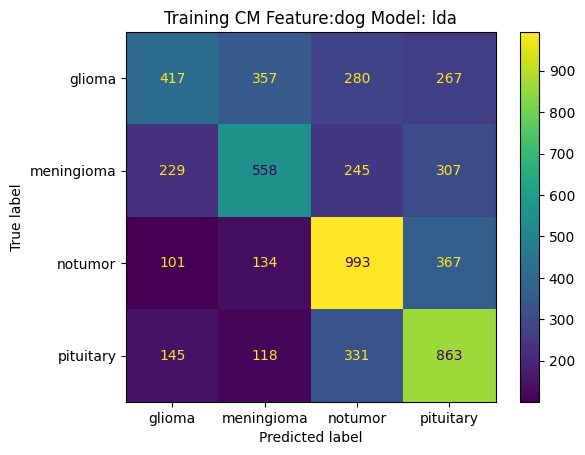

(5712, 4)


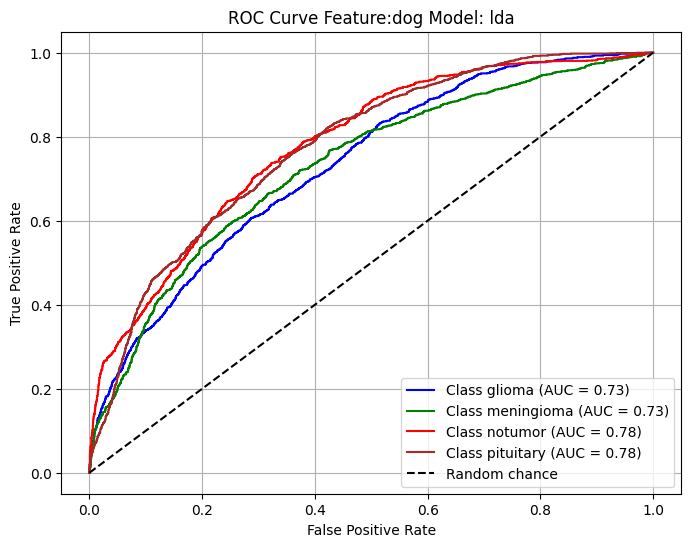

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

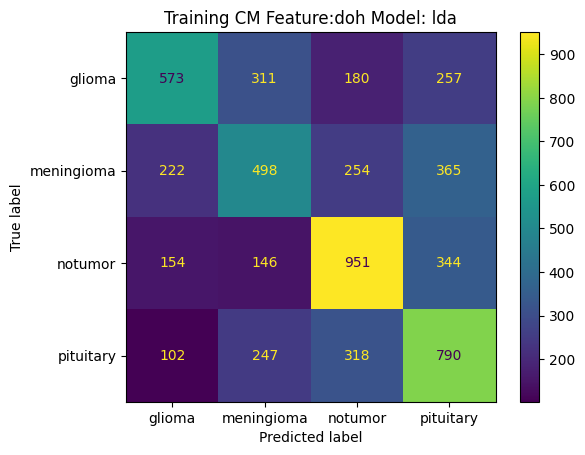

(5712, 4)


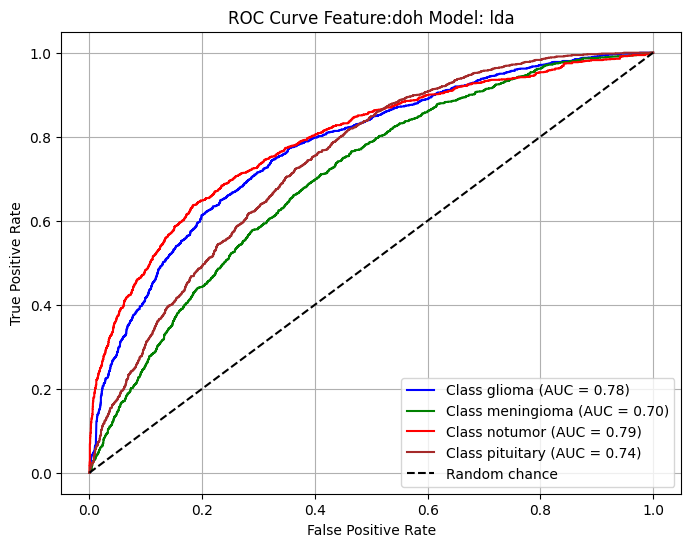

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

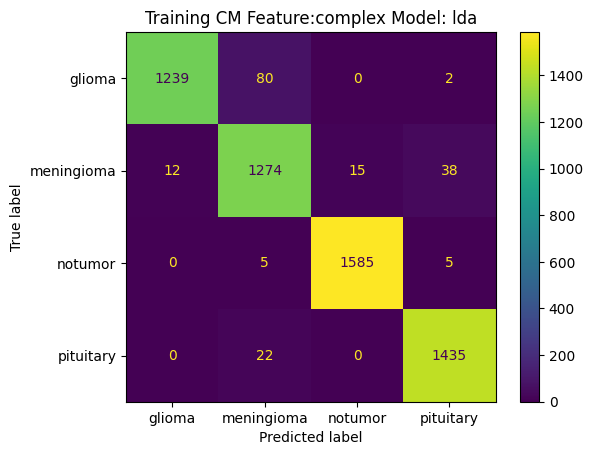

(5712, 4)


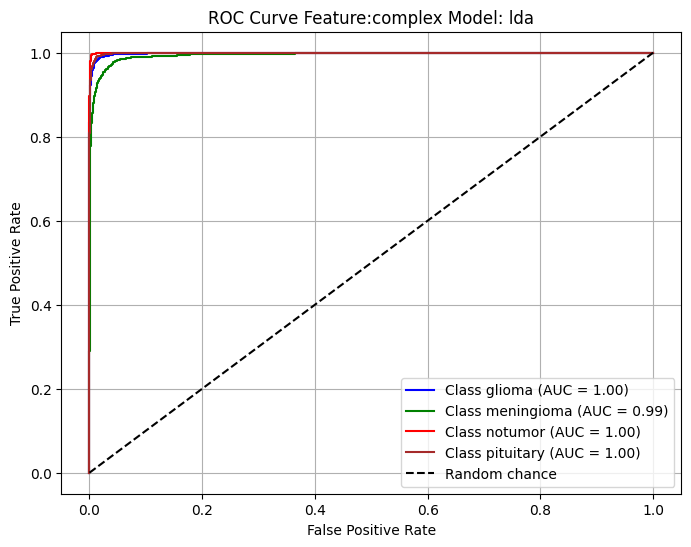

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

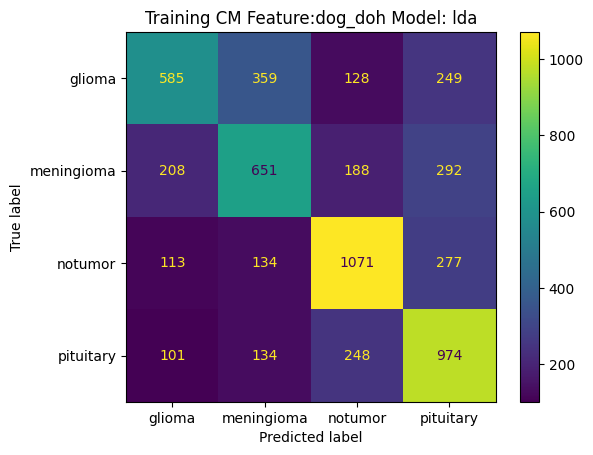

(5712, 4)


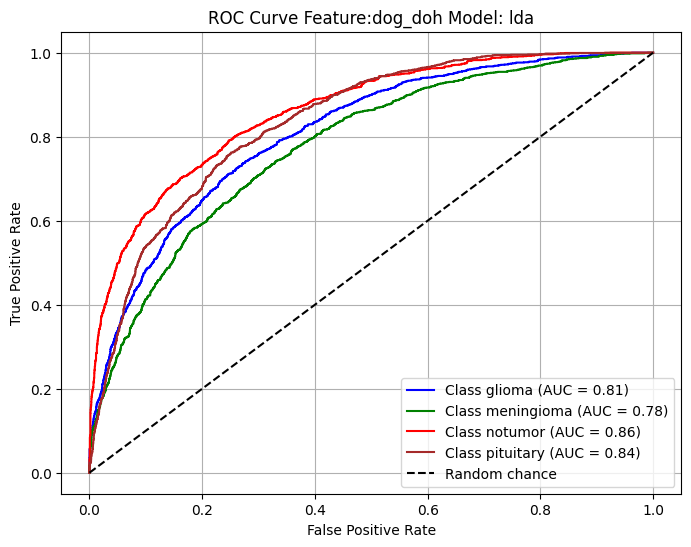

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

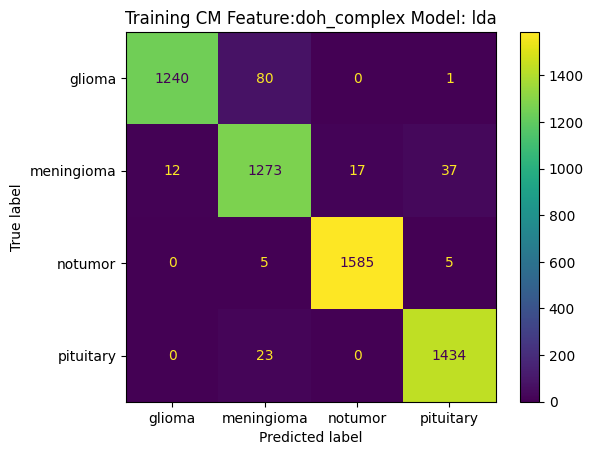

(5712, 4)


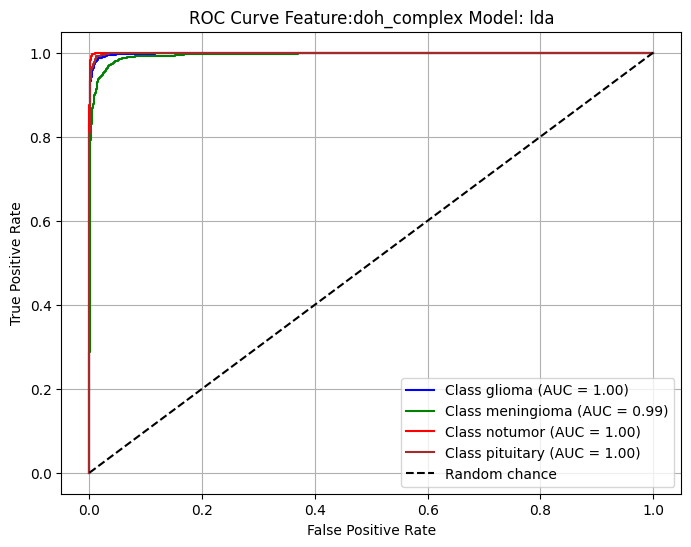

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

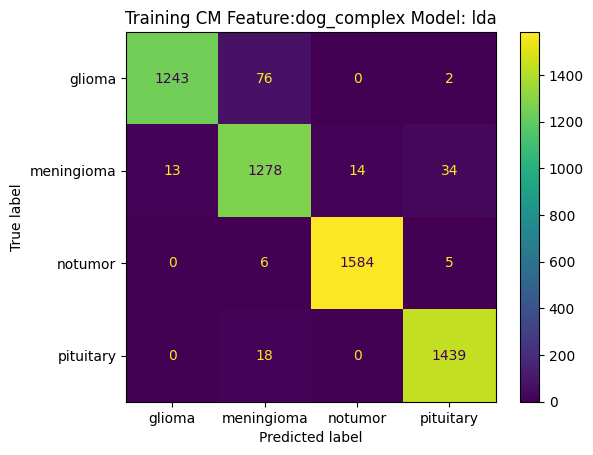

(5712, 4)


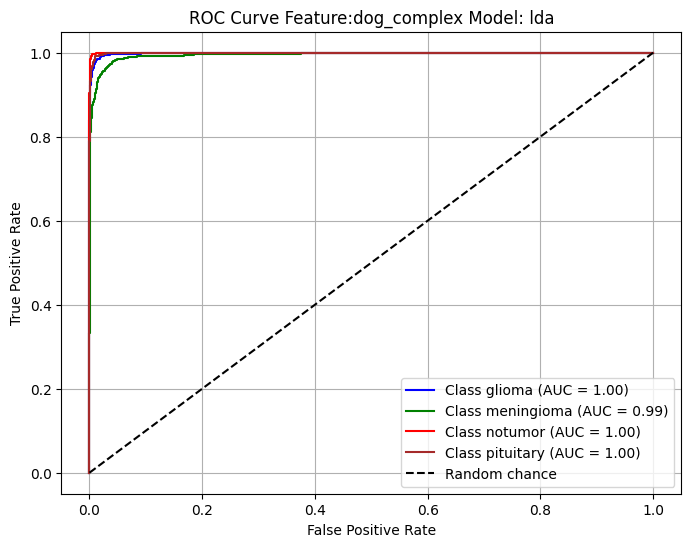

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

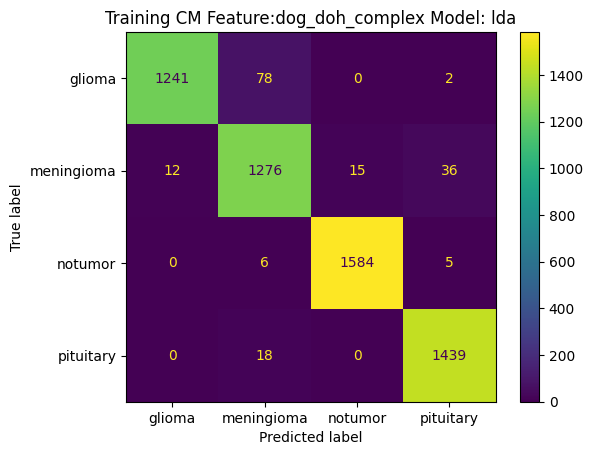

(5712, 4)


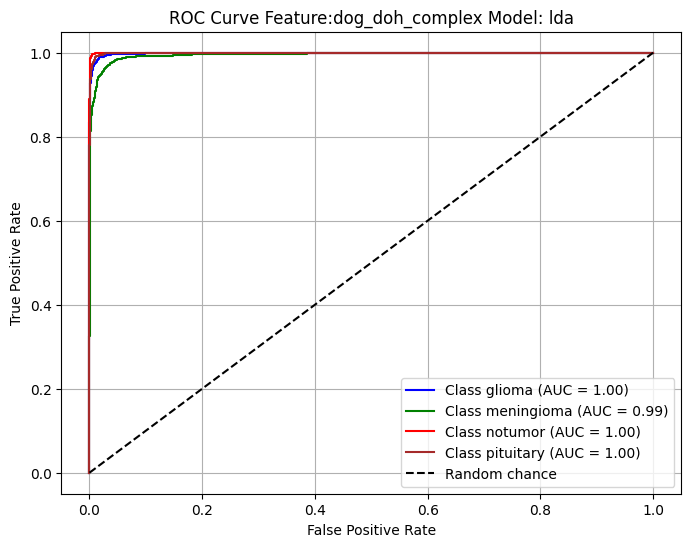

            feature model_type  accuracy_score  macro_precision  macro_recall  \
0               dog   logistic        0.479867         0.478606      0.471210   
1               doh   logistic        0.471639         0.460386      0.465640   
2           complex   logistic        0.996849         0.996661      0.996664   
3           dog_doh   logistic        0.543592         0.541922      0.537242   
4       doh_complex   logistic        0.996499         0.996302      0.996288   
5       dog_complex   logistic        0.996499         0.996321      0.996306   
6   dog_doh_complex   logistic        0.996674         0.996506      0.996495   
7               dog         rf        0.556723         0.609044      0.547355   
8               doh         rf        0.591912         0.582174      0.576569   
9           complex         rf        0.819328         0.820944      0.810693   
10          dog_doh         rf        0.660014         0.695001      0.647923   
11      doh_complex         

In [67]:
lda_models = {}
for feature in features.keys():
    lda_model, results = train_model(features[feature], y_train, classes=le.classes_, model_type='lda', feature=feature)
    lda_models[feature] = lda_model
    all_results.loc[len(all_results)] = results

print(all_results)

In [68]:
lda_models

{'dog': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'doh': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'complex': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'dog_doh': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'doh_complex': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'dog_complex': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),
 'dog_doh_complex': LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')}

In [99]:
save_models(lda_models, 'lda')

saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=dog to path=models/lda_dog.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=doh to path=models/lda_doh.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=complex to path=models/lda_complex.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=dog_doh to path=models/lda_dog_doh.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=doh_complex to path=models/lda_doh_complex.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=dog_complex to path=models/lda_dog_complex.joblib
saved model=LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr') for feature=dog_doh_complex to path=models/lda_dog_doh_complex.joblib


### Quadratic Discriminant Analysis

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   0.1s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END ......................................reg_param=1.0; total time=   0.0s
[CV] END ......................................re

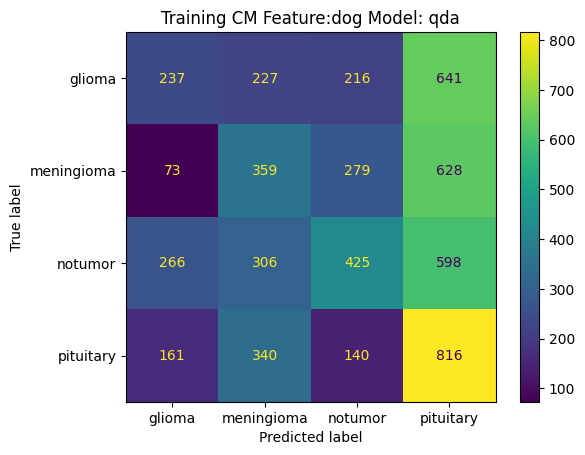

(5712, 4)


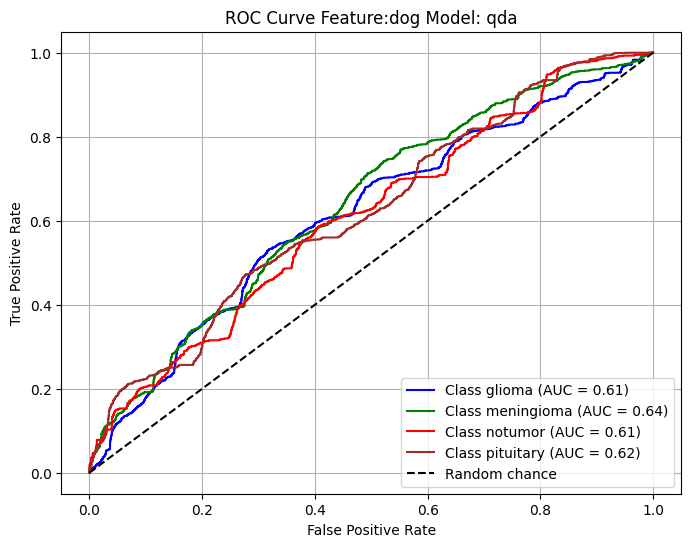

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END ......................................reg_param=1.0; total time=   0.0s
[CV] END ......................................re

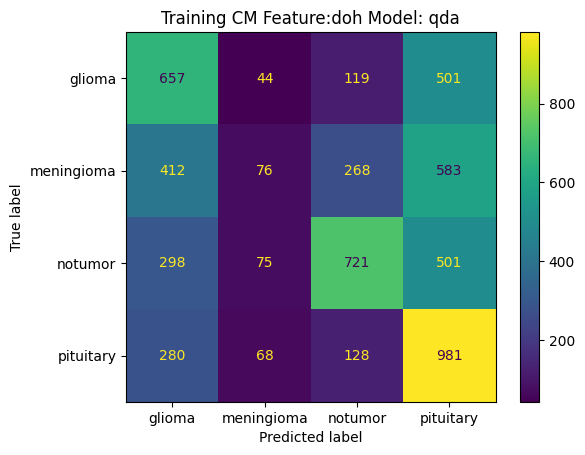

(5712, 4)


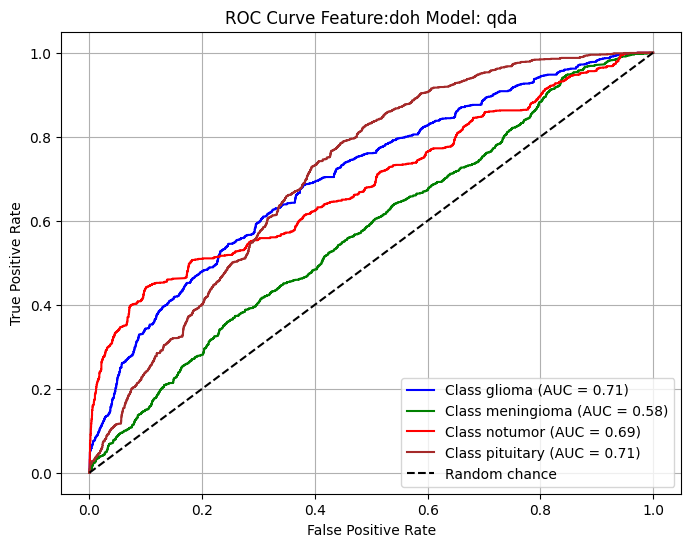

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   2.8s
[CV] END ......................................reg_param=0.5; total time=   7.2s
[CV] END ......................................reg_param=0.5; total time=   2.7s
[CV] END ......................................reg_param=0.5; total time=   3.1s
[CV] END ......................................reg_param=0.5; total time=   2.8s
[CV] END .....................................reg_param=0.75; total time=   7.1s
[CV] END .....................................reg_param=0.75; total time=   2.8s
[CV] END .....................................reg_param=0.75; total time=   2.6s
[CV] END .....................................reg_param=0.75; total time=   2.9s
[CV] END .....................................reg_param=0.75; total time=   7.2s
[CV] END ......................................reg_param=1.0; total time=   2.9s
[CV] END ......................................re

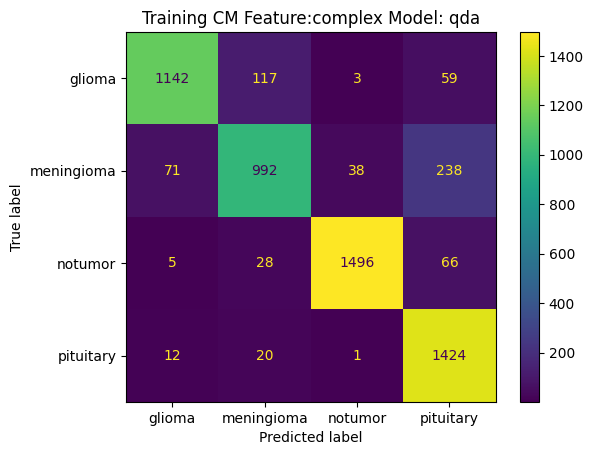

(5712, 4)


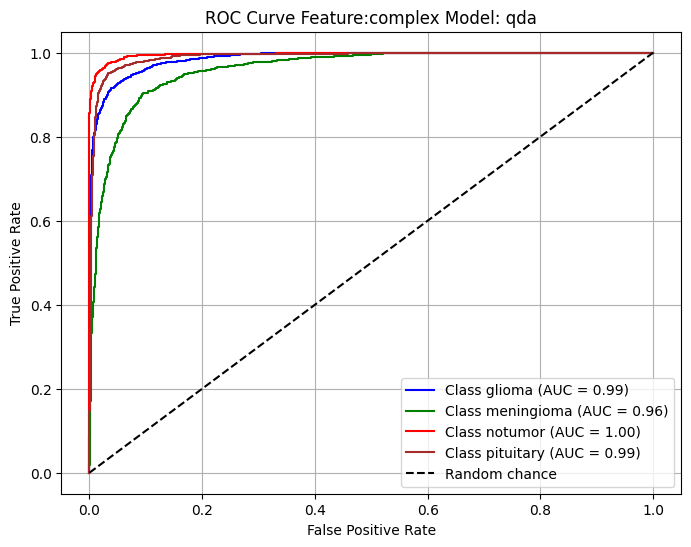

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END ......................................reg_param=0.5; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END .....................................reg_param=0.75; total time=   0.0s
[CV] END ......................................reg_param=1.0; total time=   0.0s
[CV] END ......................................re

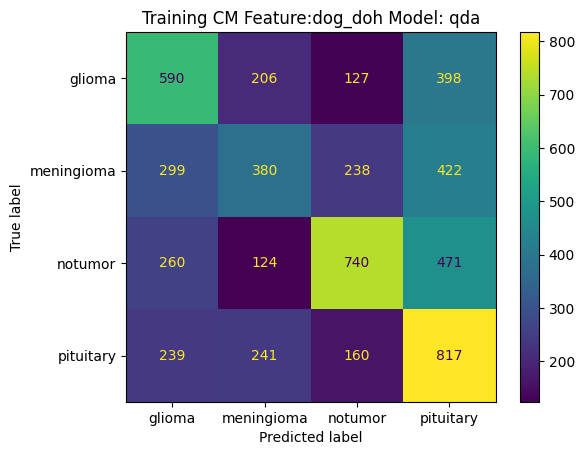

(5712, 4)


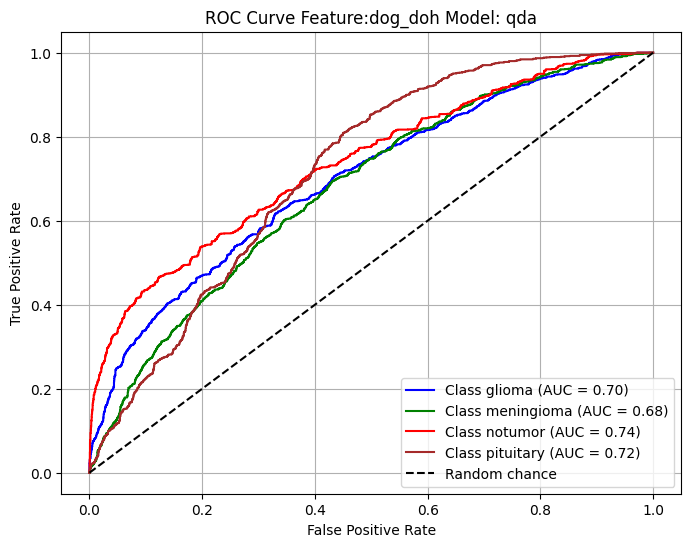

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   6.0s
[CV] END ......................................reg_param=0.5; total time=   3.4s
[CV] END ......................................reg_param=0.5; total time=   2.9s
[CV] END ......................................reg_param=0.5; total time=   7.0s
[CV] END ......................................reg_param=0.5; total time=   3.2s
[CV] END .....................................reg_param=0.75; total time=   2.9s
[CV] END .....................................reg_param=0.75; total time=   4.1s
[CV] END .....................................reg_param=0.75; total time=   7.2s
[CV] END .....................................reg_param=0.75; total time=   3.3s
[CV] END .....................................reg_param=0.75; total time=   2.9s
[CV] END ......................................reg_param=1.0; total time=   3.4s
[CV] END ......................................re

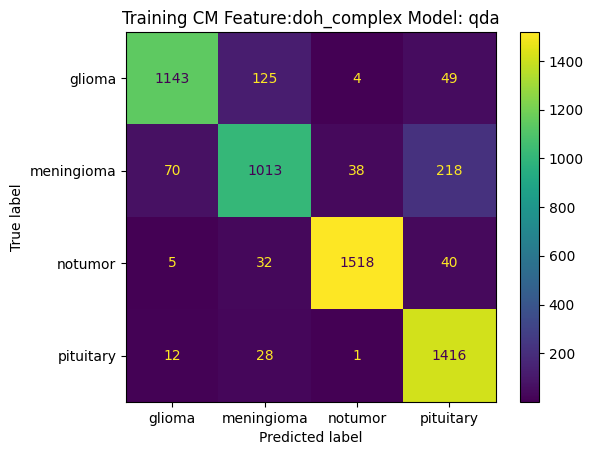

(5712, 4)


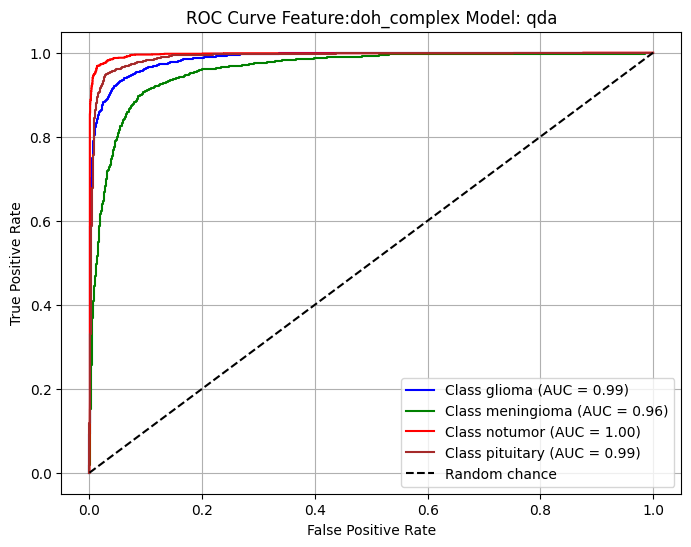

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   2.9s
[CV] END ......................................reg_param=0.5; total time=   3.4s
[CV] END ......................................reg_param=0.5; total time=   6.4s
[CV] END ......................................reg_param=0.5; total time=   3.0s
[CV] END ......................................reg_param=0.5; total time=   3.3s
[CV] END .....................................reg_param=0.75; total time=   4.7s
[CV] END .....................................reg_param=0.75; total time=   5.5s
[CV] END .....................................reg_param=0.75; total time=   2.8s
[CV] END .....................................reg_param=0.75; total time=   2.8s
[CV] END .....................................reg_param=0.75; total time=   6.6s
[CV] END ......................................reg_param=1.0; total time=   3.8s
[CV] END ......................................re

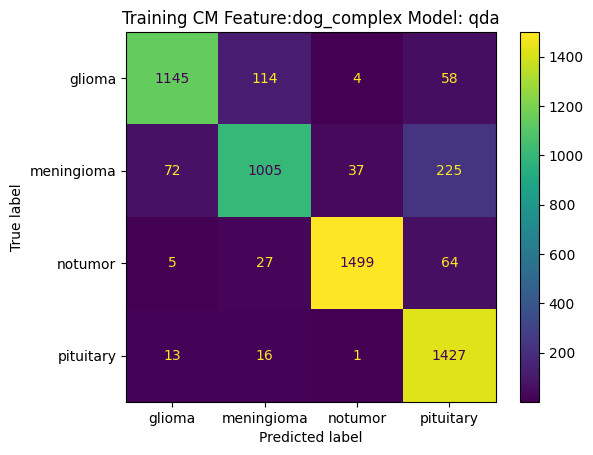

(5712, 4)


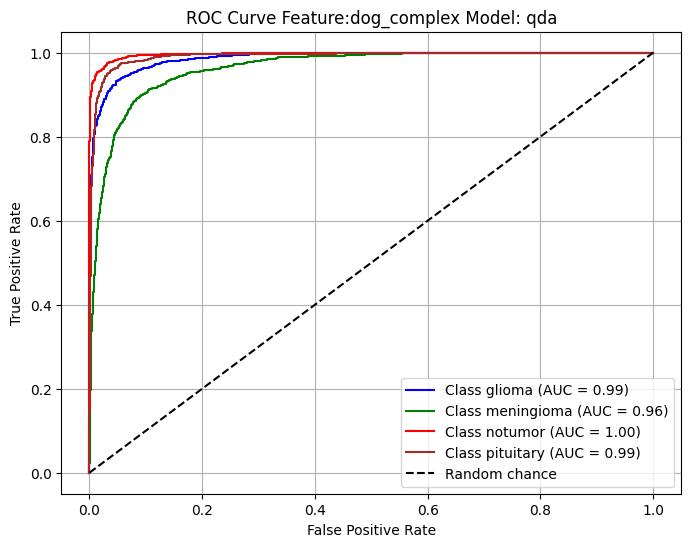

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ......................................reg_param=0.5; total time=   7.3s
[CV] END ......................................reg_param=0.5; total time=   3.0s
[CV] END ......................................reg_param=0.5; total time=   3.4s
[CV] END ......................................reg_param=0.5; total time=   3.9s
[CV] END ......................................reg_param=0.5; total time=   6.5s
[CV] END .....................................reg_param=0.75; total time=   3.0s
[CV] END .....................................reg_param=0.75; total time=   3.1s
[CV] END .....................................reg_param=0.75; total time=   7.3s
[CV] END .....................................reg_param=0.75; total time=   2.9s
[CV] END .....................................reg_param=0.75; total time=   3.1s
[CV] END ......................................reg_param=1.0; total time=   3.0s
[CV] END ......................................re

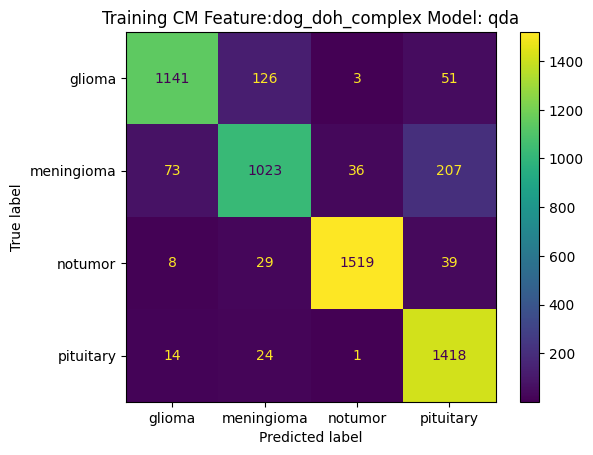

(5712, 4)


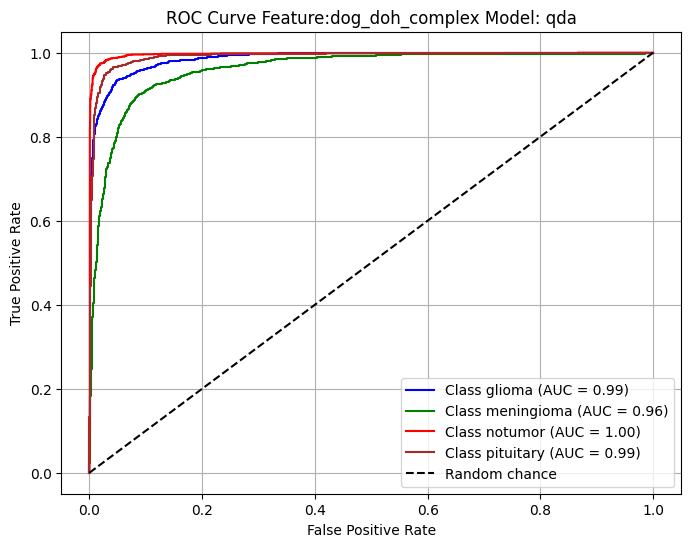

            feature model_type  accuracy_score  macro_precision  macro_recall  \
0               dog   logistic        0.479867         0.478606      0.471210   
1               doh   logistic        0.471639         0.460386      0.465640   
2           complex   logistic        0.996849         0.996661      0.996664   
3           dog_doh   logistic        0.543592         0.541922      0.537242   
4       doh_complex   logistic        0.996499         0.996302      0.996288   
5       dog_complex   logistic        0.996499         0.996321      0.996306   
6   dog_doh_complex   logistic        0.996674         0.996506      0.996495   
7               dog         rf        0.556723         0.609044      0.547355   
8               doh         rf        0.591912         0.582174      0.576569   
9           complex         rf        0.819328         0.820944      0.810693   
10          dog_doh         rf        0.660014         0.695001      0.647923   
11      doh_complex         

In [70]:
qda_models = {}
for feature in features.keys():
    qda_model, results = train_model(features[feature], y_train, classes=le.classes_, model_type='qda', feature=feature)
    qda_models[feature] = qda_model
    all_results.loc[len(all_results)] = results

print(all_results)

In [71]:
qda_models

{'dog': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'doh': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'complex': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'dog_doh': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'doh_complex': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'dog_complex': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)),
 'dog_doh_complex': QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5))}

In [100]:
save_models(qda_models, 'qda')

saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=dog to path=models/qda_dog.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=doh to path=models/qda_doh.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=complex to path=models/qda_complex.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=dog_doh to path=models/qda_dog_doh.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=doh_complex to path=models/qda_doh_complex.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=dog_complex to path=models/qda_dog_complex.joblib
saved model=QuadraticDiscriminantAnalysis(reg_param=np.float64(0.5)) for feature=dog_doh_complex to path=models/qda_dog_doh_complex.joblib


In [107]:
all_results

feature model_type  accuracy_score  macro_precision  macro_recall  \
0               dog   logistic        0.479867         0.478606      0.471210   
1               doh   logistic        0.471639         0.460386      0.465640   
2           complex   logistic        0.996849         0.996661      0.996664   
3           dog_doh   logistic        0.543592         0.541922      0.537242   
4       doh_complex   logistic        0.996499         0.996302      0.996288   
5       dog_complex   logistic        0.996499         0.996321      0.996306   
6   dog_doh_complex   logistic        0.996674         0.996506      0.996495   
7               dog         rf        0.556723         0.609044      0.547355   
8               doh         rf        0.591912         0.582174      0.576569   
9           complex         rf        0.819328         0.820944      0.810693   
10          dog_doh         rf        0.660014         0.695001      0.647923   
11      doh_complex         rf        0.825455         0.825312      0.816667   
12      dog_complex         rf        0.836485         0.840316      0.828955   
13  dog_doh_complex         rf        0.830357         0.833597      0.822259   
14              dog        lda        0.495623         0.490267      0.486821   
15              doh        lda        0.492297         0.491954      0.486032   
16          complex        lda        0.968662         0.968287      0.967003   
17          dog_doh        lda        0.574405         0.572224      0.567250   
18      doh_complex        lda        0.968487         0.968122      0.966834   
19      dog_complex        lda        0.970588         0.970154      0.969037   
20  dog_doh_complex        lda        0.969888         0.969502      0.968285   
21              dog        qda        0.321604         0.329513      0.318508   
22              doh        qda        0.426296         0.413380      0.419862   
23          complex        qda        0.884804         0.888851      0.880157   
24          dog_doh        qda        0.442402         0.449301      0.438779   
25      doh_complex        qda        0.891106         0.892280      0.886343   
26      dog_complex        qda        0.888655         0.892289      0.884137   
27  dog_doh_complex        qda        0.893032         0.893846      0.888332   

    macro_f1  micro_precision  micro_recall  micro_f1  training_time  
0   0.468475         0.479867      0.479867  0.479867       5.309745  
1   0.455994         0.471639      0.471639  0.471639      13.400570  
2   0.996662         0.996849      0.996849  0.996849     359.831393  
3   0.536734         0.543592      0.543592  0.543592      38.301736  
4   0.996294         0.996499      0.996499  0.996499     470.841210  
5   0.996312         0.996499      0.996499  0.996499     396.762333  
6   0.996500         0.996674      0.996674  0.996674     494.599391  
7   0.546955         0.556723      0.556723  0.556723      70.081841  
8   0.554256         0.591912      0.591912  0.591912      81.260276  
9   0.806925         0.819328      0.819328  0.819328     392.390809  
10  0.644010         0.660014      0.660014  0.660014      88.127259  
11  0.812744         0.825455      0.825455  0.825455     378.685734  
12  0.827706         0.836485      0.836485  0.836485     372.222373  
13  0.820180         0.830357      0.830357  0.830357     379.894803  
14  0.482034         0.495623      0.495623  0.495623       0.265162  
15  0.485893         0.492297      0.492297  0.492297       0.275635  
16  0.967395         0.968662      0.968662  0.968662      17.464336  
17  0.565705         0.574405      0.574405  0.574405       0.415830  
18  0.967236         0.968487      0.968487  0.968487      18.195419  
19  0.969378         0.970588      0.970588  0.970588      19.450322  
20  0.968658         0.969888      0.969888  0.969888      18.242172  
21  0.305986         0.321604      0.321604  0.321604       0.249180  
22  0.383665         0.426296

In [105]:
all_results.to_csv('training_results.csv')

## VI. Final Test Evaluation

In [13]:
aligned_test_features = pd.read_csv('aligned_testing_features.csv')

In [15]:
aligned_test_features, dims, enc = clean_df(
    df=aligned_test_features,
    label_col="target",
    feat_cols=["feat_canny", "feat_vec", "feat_dog", "feat_doh"]
)

In [49]:
parsed_aligned_test_features  = parse_aligned_features(aligned_test_features, ['feat_canny', 'feat_vec', 'feat_dog', 'feat_doh'])
parsed_aligned_test_features

{'filepath': array([['/Testing/glioma/Te-glTr_0000.jpg'],
        ['/Testing/glioma/Te-glTr_0001.jpg'],
        ['/Testing/glioma/Te-glTr_0002.jpg'],
        ...,
        ['/Testing/pituitary/Te-pi_0297.jpg'],
        ['/Testing/pituitary/Te-pi_0298.jpg'],
        ['/Testing/pituitary/Te-pi_0299.jpg']], dtype=object),
 'target': array([0, 0, 0, ..., 3, 3, 3], dtype=int32),
 'feat_canny': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'feat_vec': array([[ 0.49438477,  0.70654297,  0.5390625 , ..., -0.41601562,
          0.62207031, -1.66113281],
        [ 0.77636719,  0.24938965,  0.13012695, ..., -0.40917969,
          0.62158203, -2.11328125],
        [ 0.78613281,  0.87109375, -0.05541992, ..., -0.32373047,
          0.47949219, -1.96289062],
        ...,
        [ 0.20166016, -0.29345703,  0.17687988, ...,  0.16918945,
          0.17163086, -0.77050781],
        [ 0.57226562,  0.31054

In [84]:
X_test_dog_features = parsed_aligned_test_features['feat_dog']
X_test_doh_features = parsed_aligned_test_features['feat_doh']
X_test_complex_features = parsed_aligned_test_features['feat_vec']
y_test = parsed_aligned_test_features['target']

In [82]:
test_features = {'dog':X_test_dog_features,
            'doh':X_test_doh_features,
            'complex': X_test_complex_features,
            'dog_doh': np.concatenate((X_test_dog_features, X_test_doh_features), axis=1),
            'doh_complex': np.concatenate((X_test_doh_features, X_test_complex_features), axis=1),
            'dog_complex': np.concatenate((X_test_dog_features, X_test_complex_features), axis=1),
            'dog_doh_complex': np.concatenate((X_test_dog_features, X_test_doh_features, X_test_complex_features), axis=1)
            }

In [104]:
# load models
features_list = features.keys()
logistic_models = load_models(features_list, 'logistic')
rf_models = load_models(features_list, 'rf')
lda_models = load_models(features_list, 'lda')
qda_models = load_models(features_list, 'qda')

loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog from path=models/logistic_dog.joblib
loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=doh from path=models/logistic_doh.joblib
loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=complex from path=models/logistic_complex.joblib
loaded model=LogisticRegression(max_iter=1000) for feature=dog_doh from path=models/logistic_dog_doh.joblib
loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=doh_complex from path=models/logistic_doh_complex.joblib
loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog_complex from path=models/logistic_dog_complex.joblib
loaded model=LogisticRegression(max_iter=1000, solver='newton-cg') for feature=dog_doh_complex from path=models/logistic_dog_doh_complex.joblib
loaded model=RandomForestClassifier(max_depth=4, max_features='log2', n_estimators=110) for feature=dog from

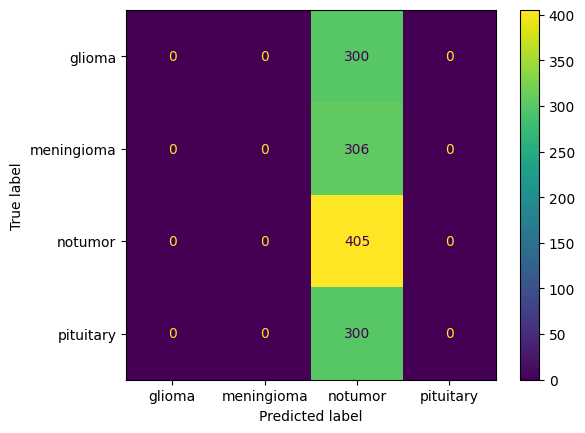

================== TESTING METRICS BASE MODEL ===================
Accuracy Score: 0.30892448512585813
Macro Precision: 0.07723112128146453
Macro Recall: 0.25
Macro F1: 0.11800699300699301
Micro Precision: 0.30892448512585813
Micro Recall: 0.30892448512585813
Micro F1: 0.30892448512585813


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
y_test_base_model = np.ones((y_test.shape)) * most_common_label

# Generate Confusion Matrix for Base Model
confusion_matrix = metrics.confusion_matrix(y_test, y_test_base_model)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = le.classes_)
cm_display.plot()
plt.show()

accuracy_score = metrics.accuracy_score(y_test, y_test_base_model)
macro_precision = metrics.precision_score(y_test,y_test_base_model,average ='macro')
macro_recall = metrics.recall_score(y_test,y_test_base_model,average='macro')
macro_f1 = metrics.f1_score(y_test,y_test_base_model,average='macro')
micro_precision = metrics.precision_score(y_test,y_test_base_model,average='micro')
micro_recall = metrics.recall_score(y_test,y_test_base_model,average='micro')
micro_f1 = metrics.f1_score(y_test,y_test_base_model,average='micro')

print("================== TESTING METRICS BASE MODEL ===================")
print("Accuracy Score: " + str(accuracy_score))
print("Macro Precision: " + str(macro_precision))
print("Macro Recall: " + str(macro_recall))
print("Macro F1: " + str(macro_f1))
print("Micro Precision: " + str(micro_precision))
print("Micro Recall: " + str(micro_recall))
print("Micro F1: " + str(micro_f1))

In [85]:
test_results = pd.DataFrame(columns = ['feature', 'model_type', 'accuracy_score', 'macro_precision', 'macro_recall', 'macro_f1',
                                      'micro_precision', 'micro_recall', 'micro_f1', 'inference_time'])

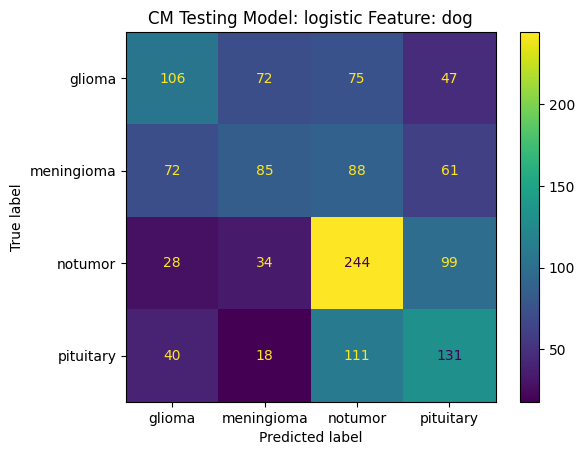

(1311, 4)


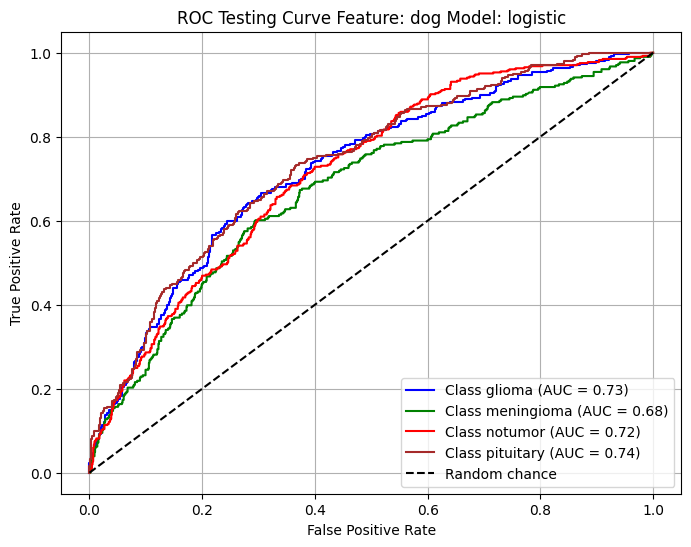

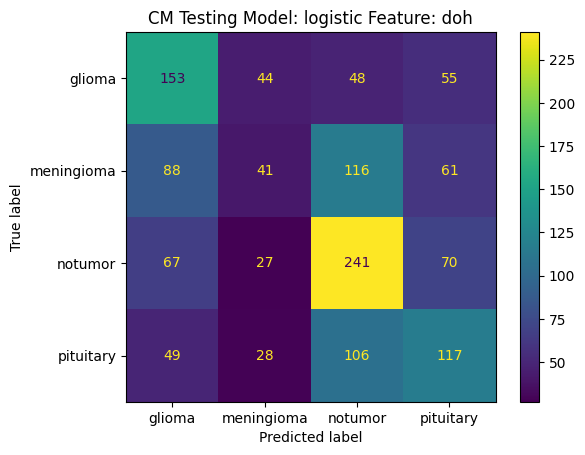

(1311, 4)


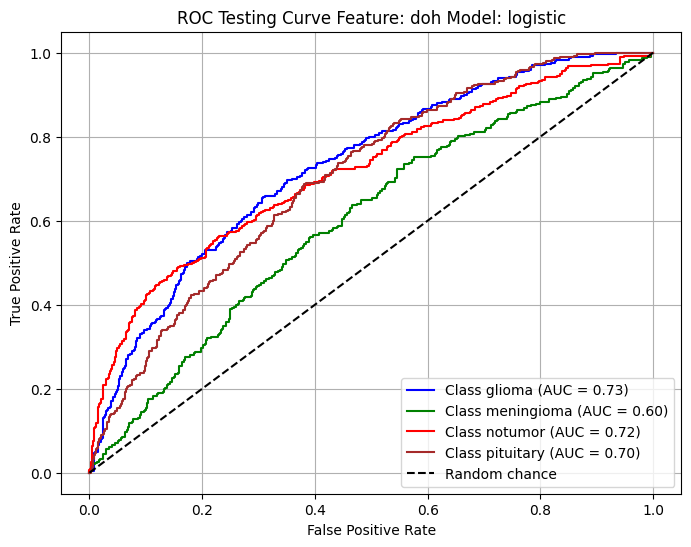

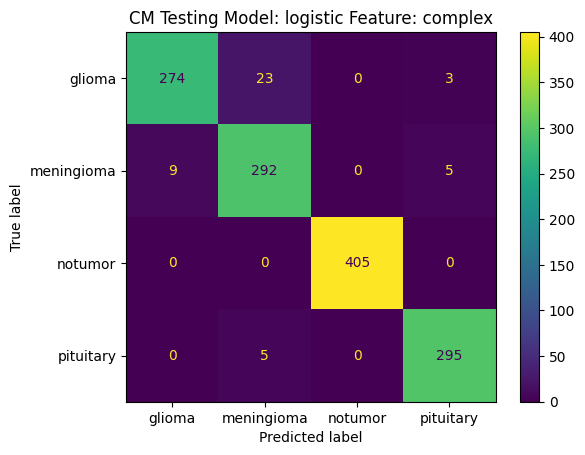

(1311, 4)


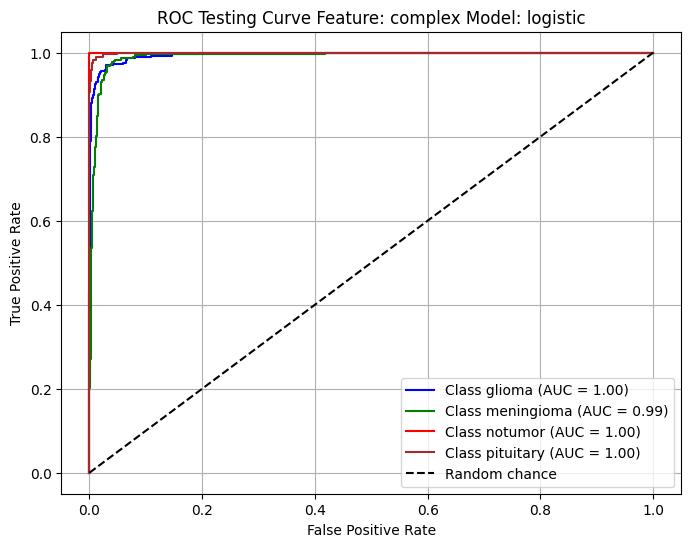

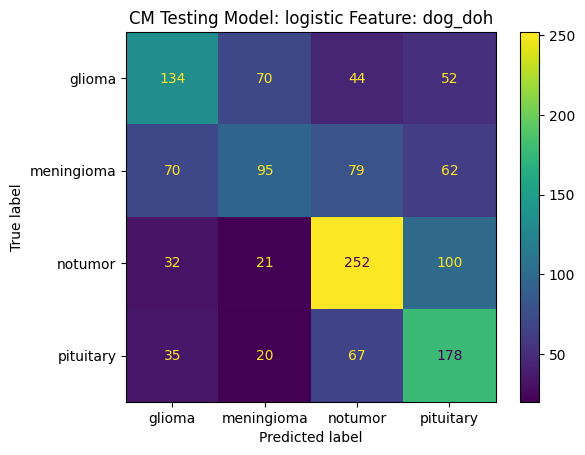

(1311, 4)


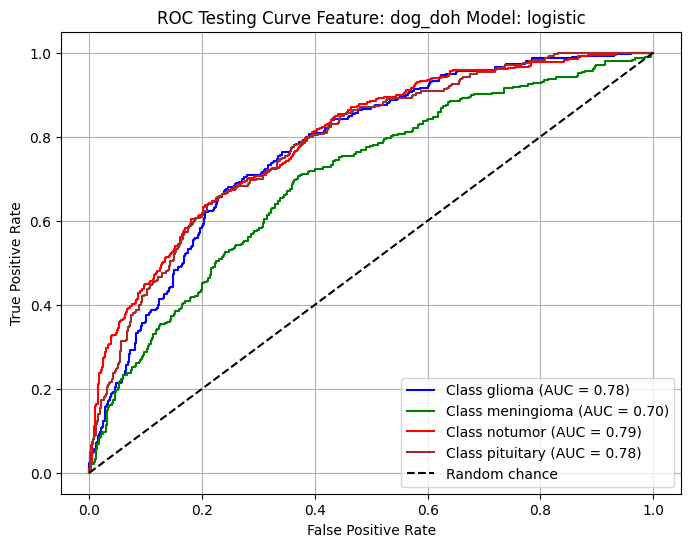

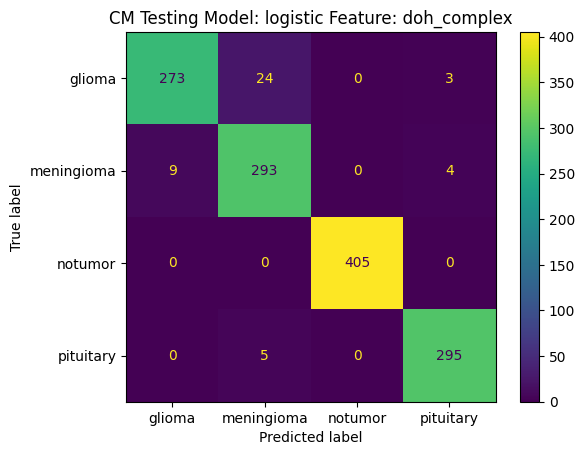

(1311, 4)


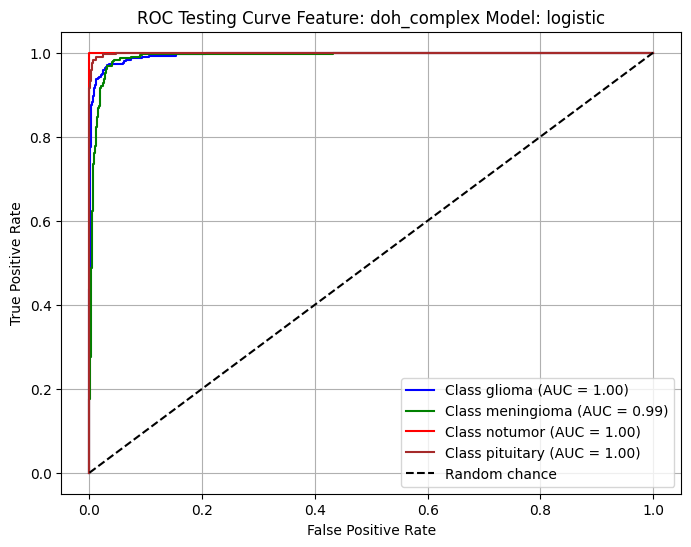

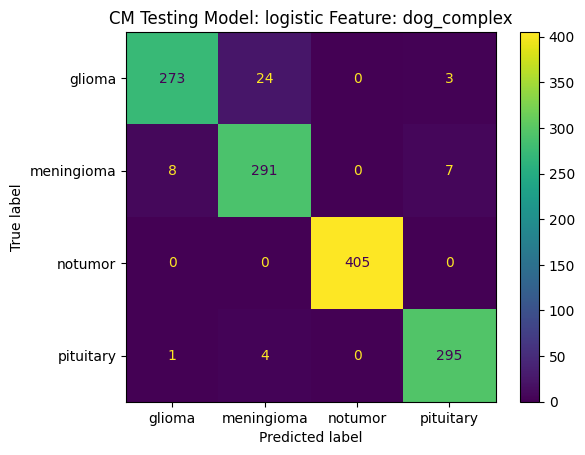

(1311, 4)


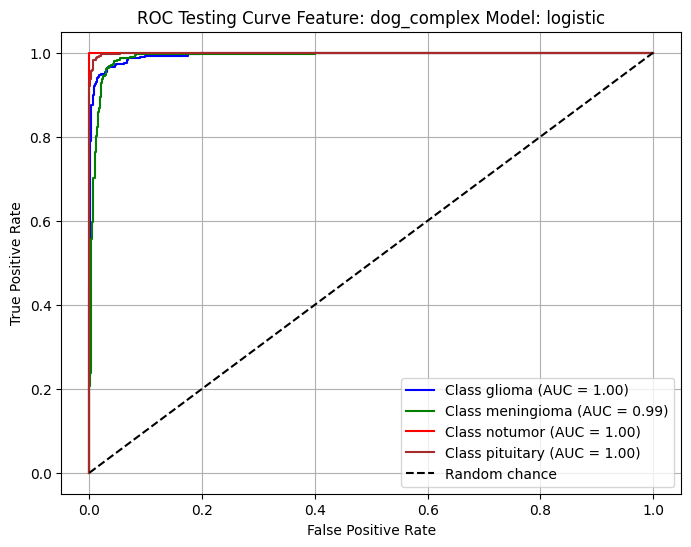

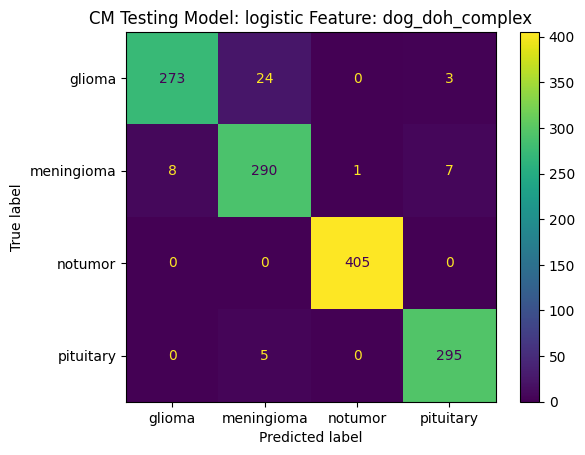

(1311, 4)


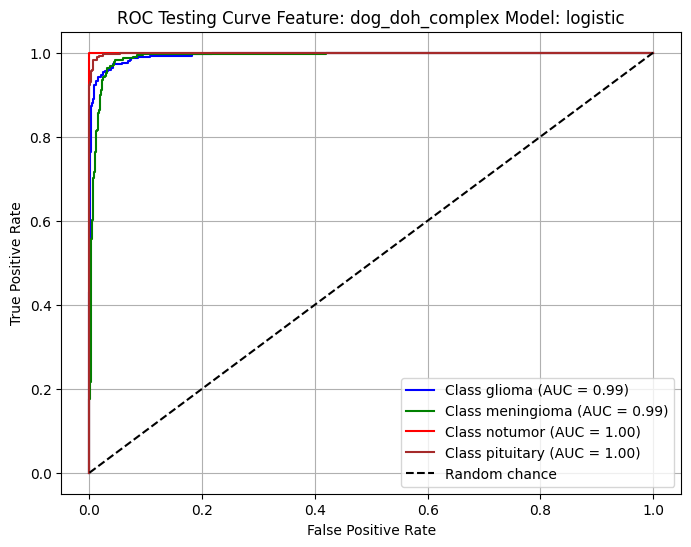

In [86]:
for feature in logistic_models.keys():
    results = test_model(logistic_models[feature], test_features[feature], y_test, classes=le.classes_, model_type='logistic', feature=feature)
    test_results.loc[len(test_results)] = results

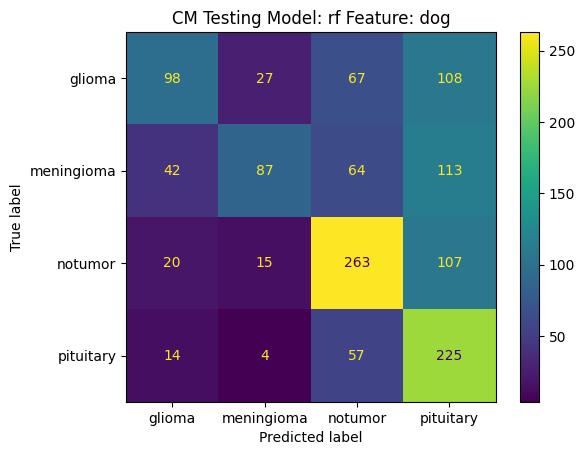

(1311, 4)


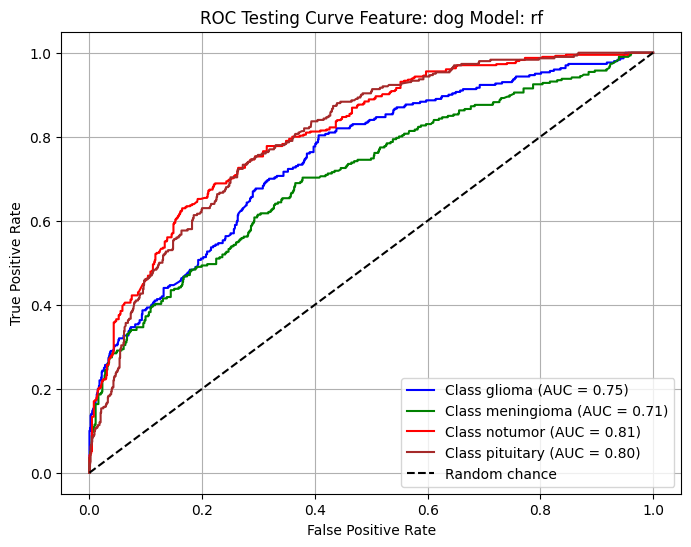

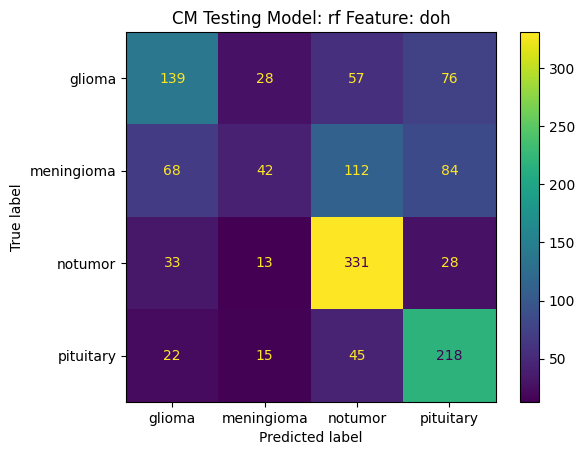

(1311, 4)


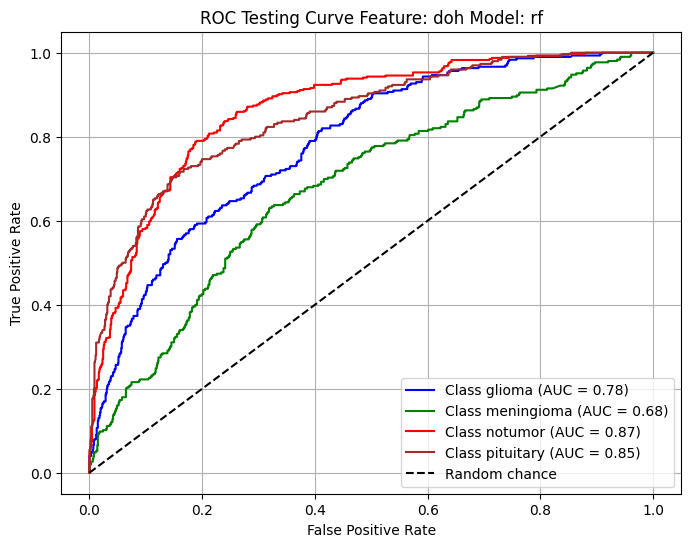

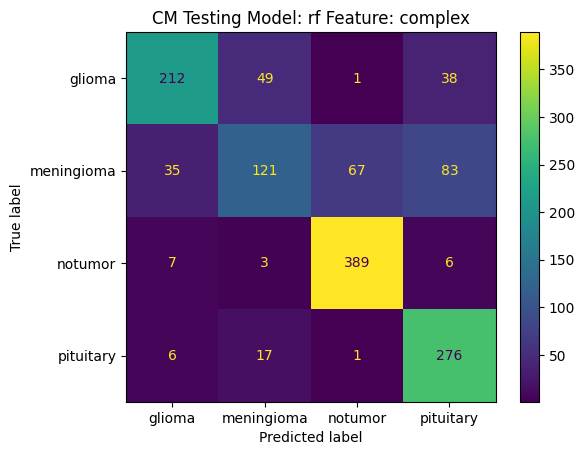

(1311, 4)


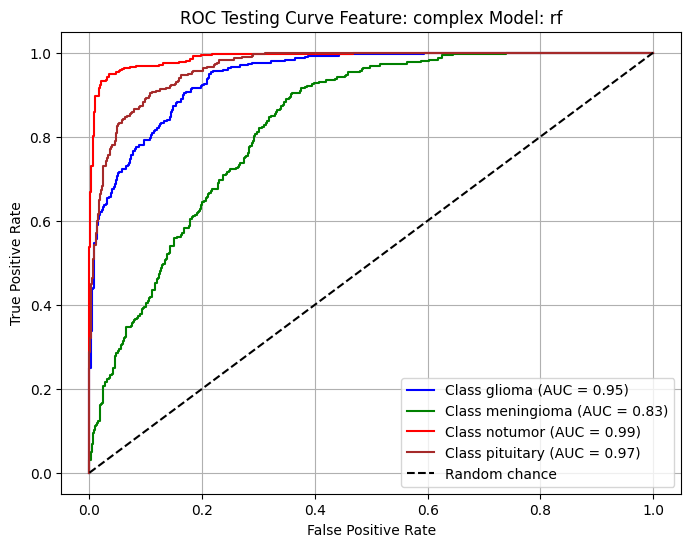

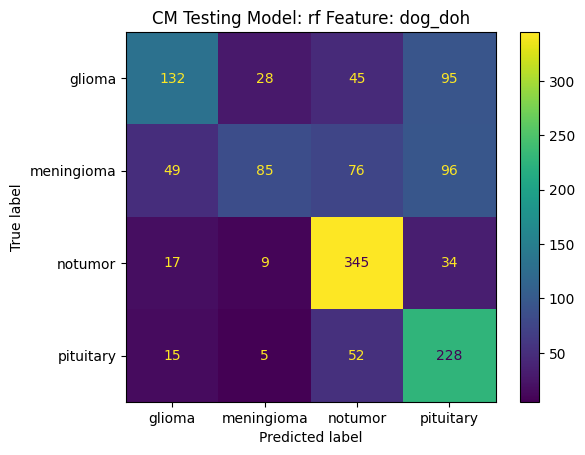

(1311, 4)


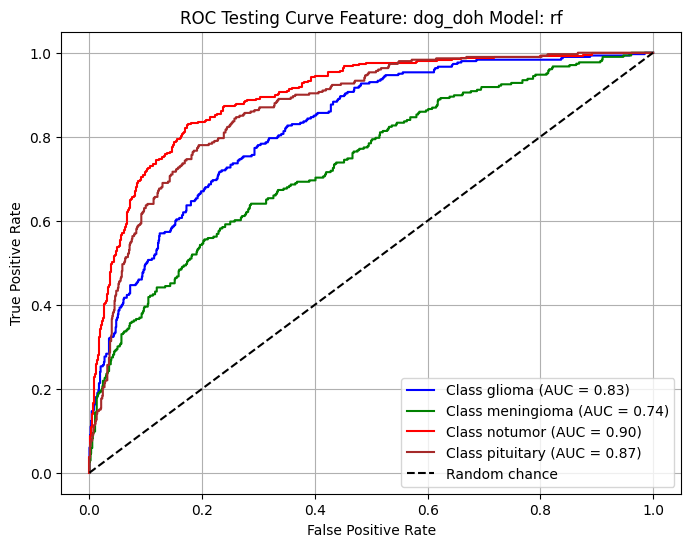

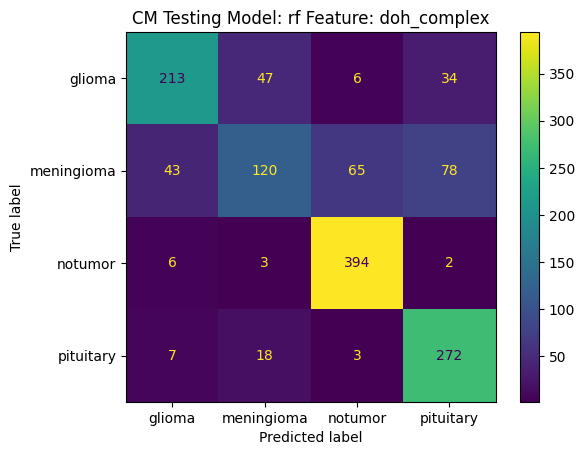

(1311, 4)


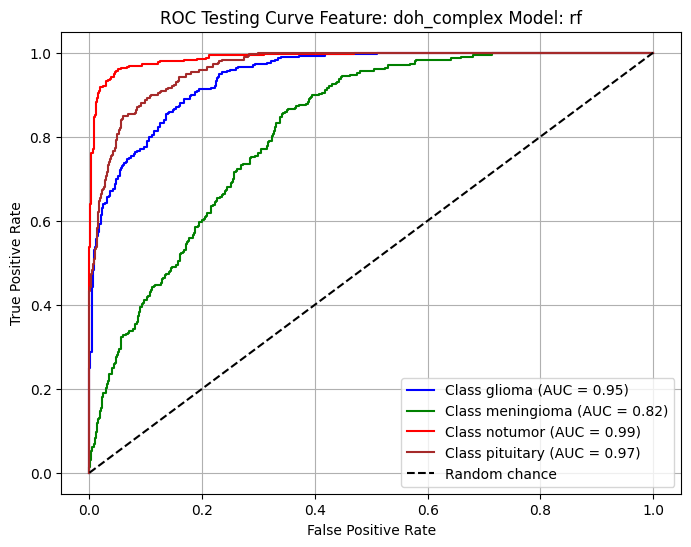

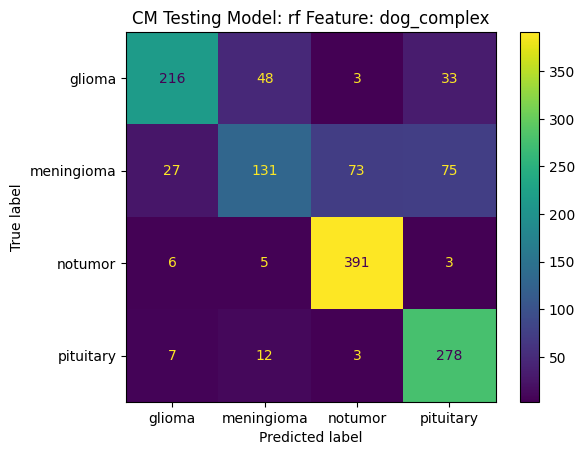

(1311, 4)


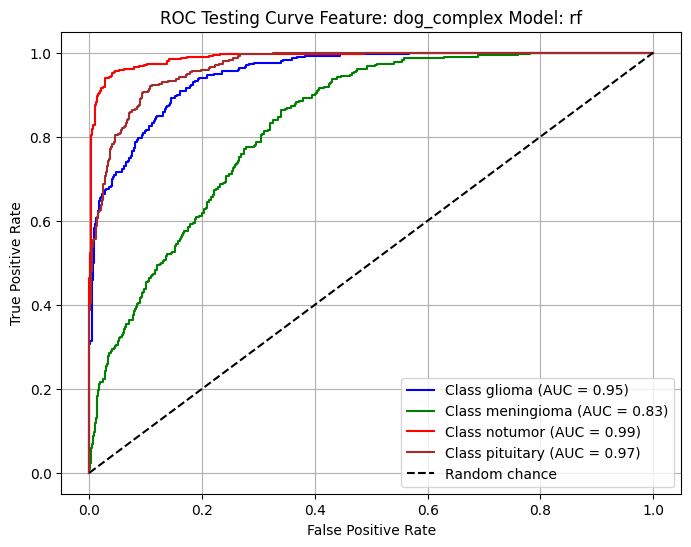

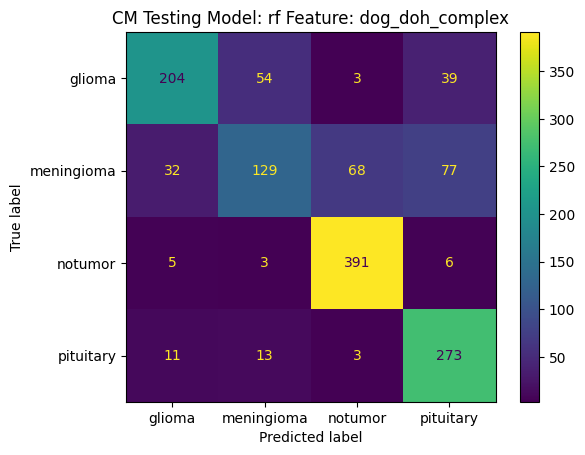

(1311, 4)


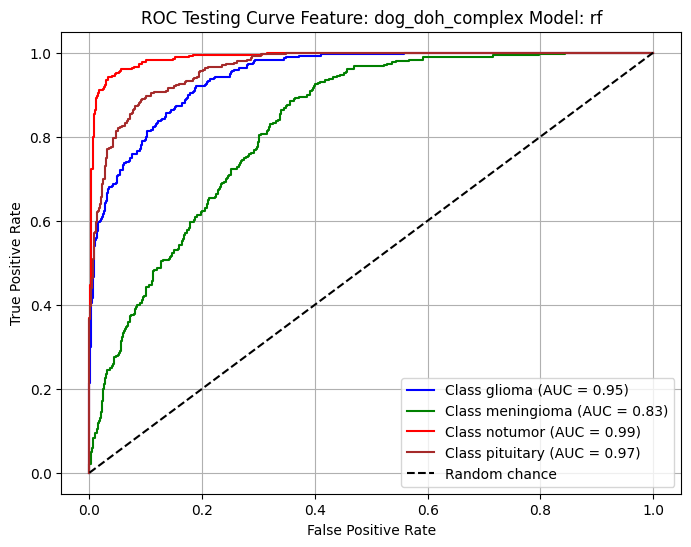

In [89]:
for feature in rf_models.keys():
    results = test_model(rf_models[feature], test_features[feature], y_test, classes=le.classes_, model_type='rf', feature=feature)
    test_results.loc[len(test_results)] = results

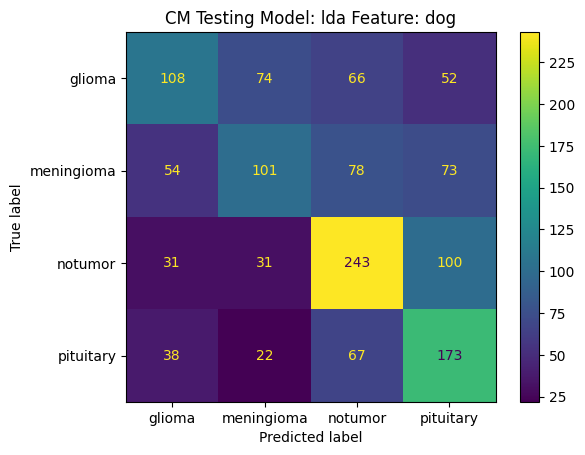

(1311, 4)


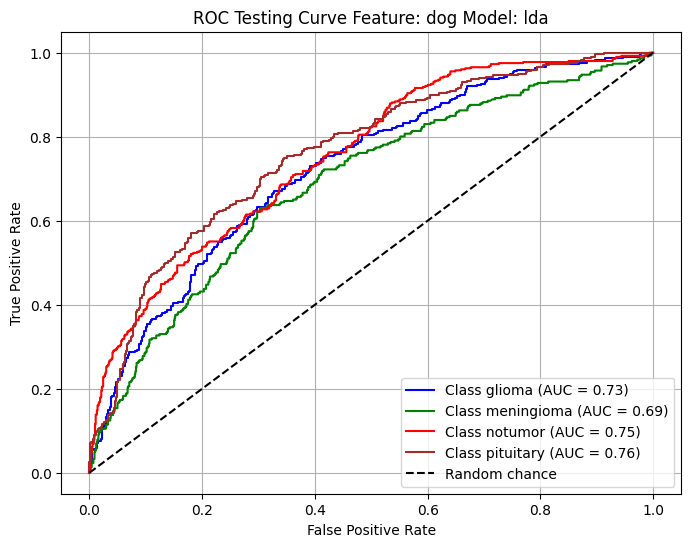

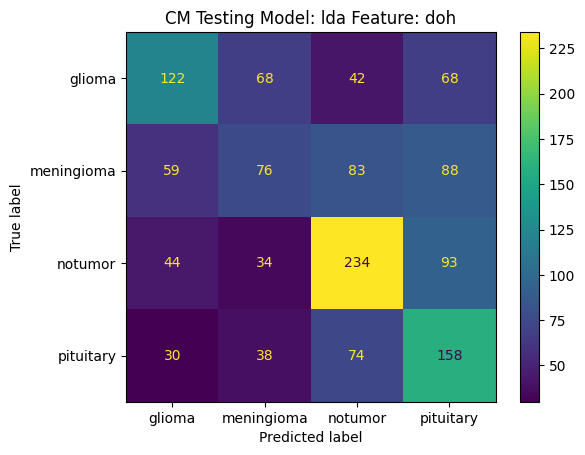

(1311, 4)


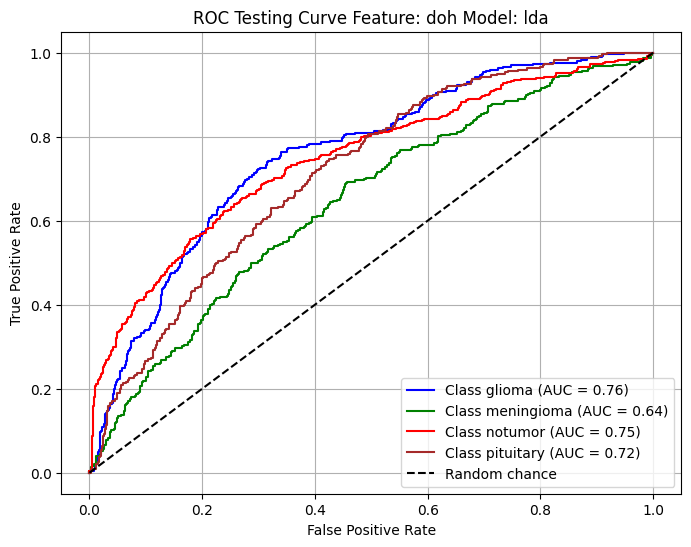

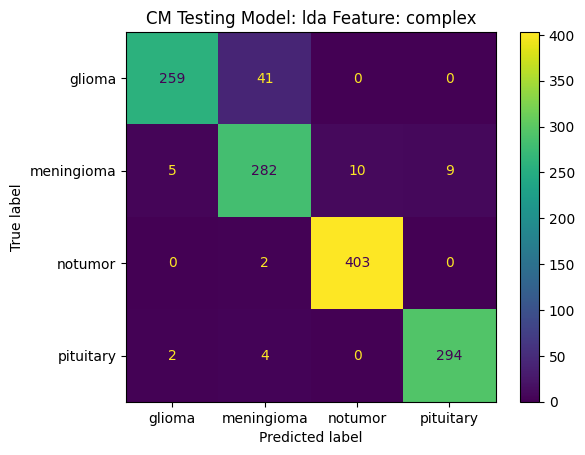

(1311, 4)


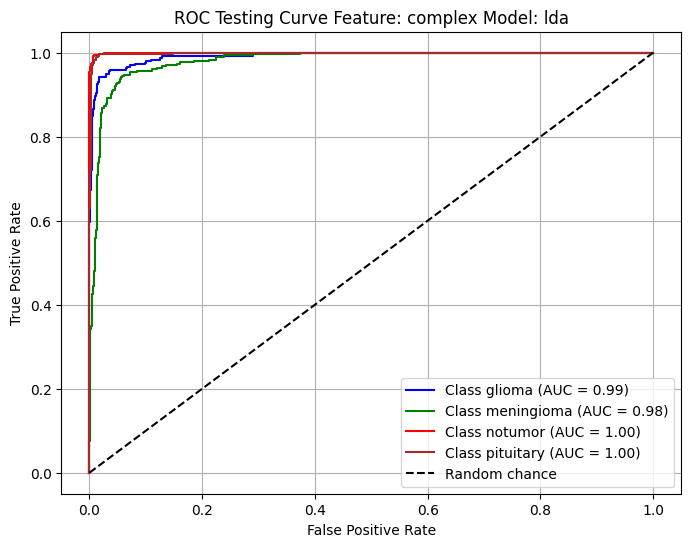

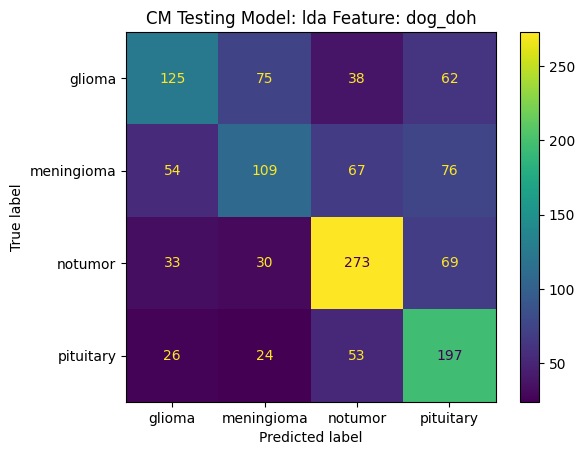

(1311, 4)


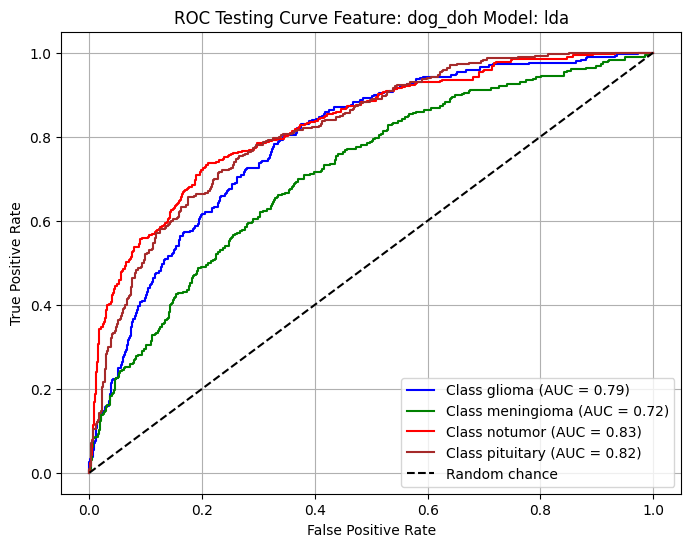

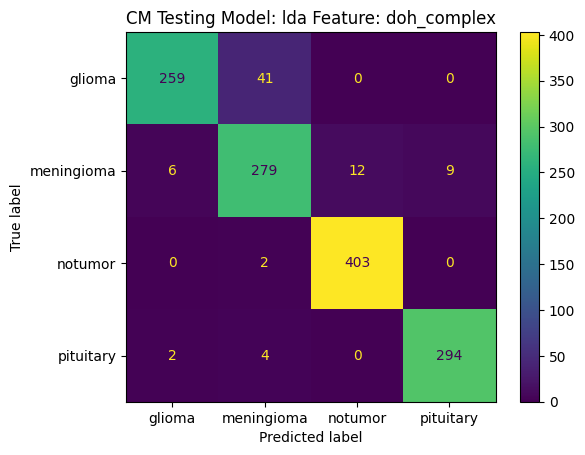

(1311, 4)


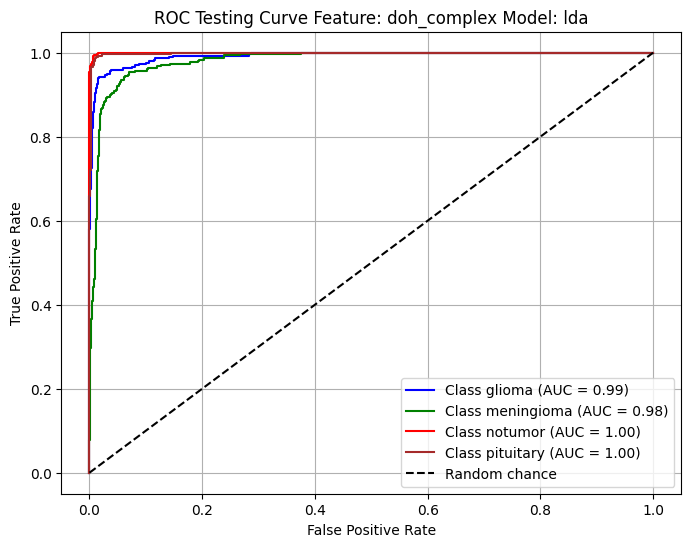

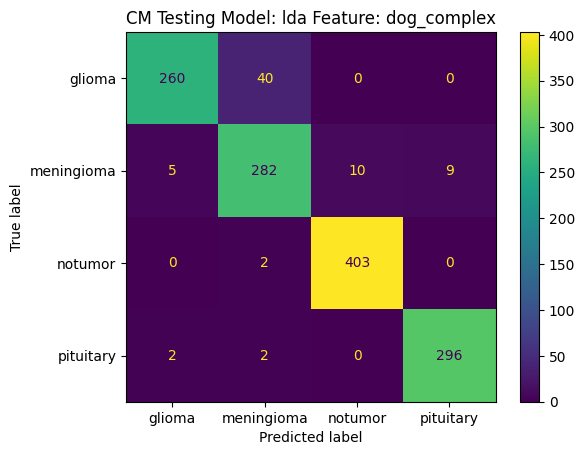

(1311, 4)


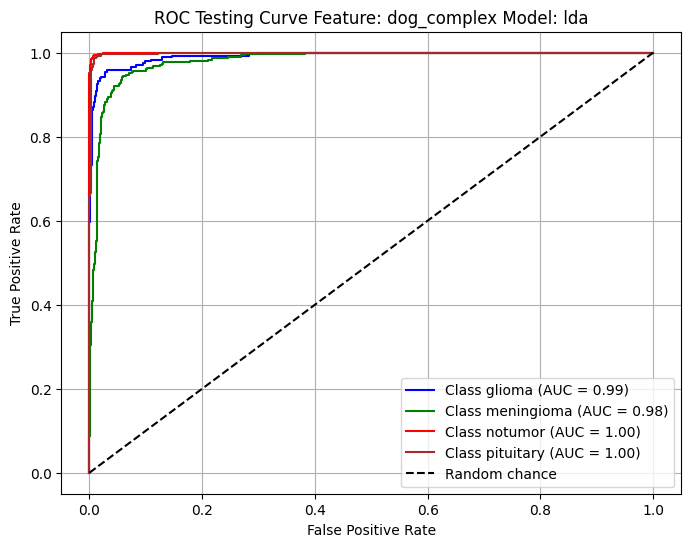

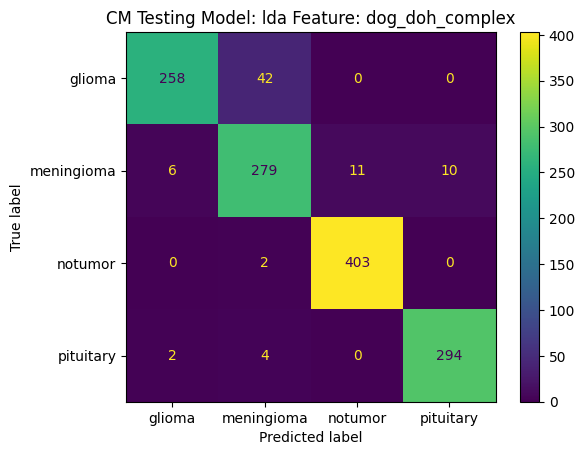

(1311, 4)


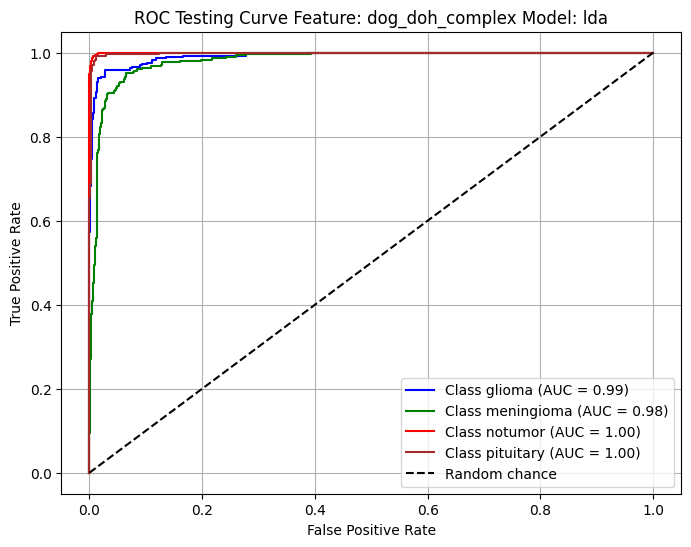

In [90]:
for feature in lda_models.keys():
    results = test_model(lda_models[feature], test_features[feature], y_test, classes=le.classes_, model_type='lda', feature=feature)
    test_results.loc[len(test_results)] = results

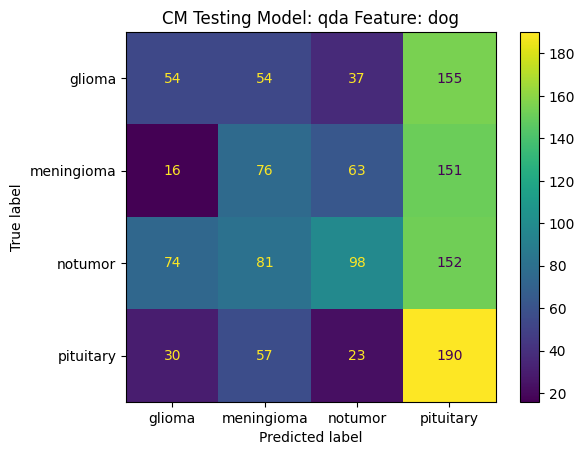

(1311, 4)


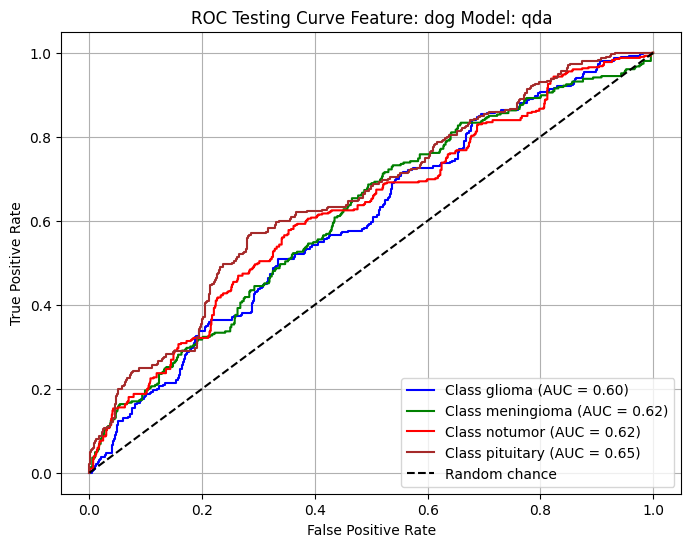

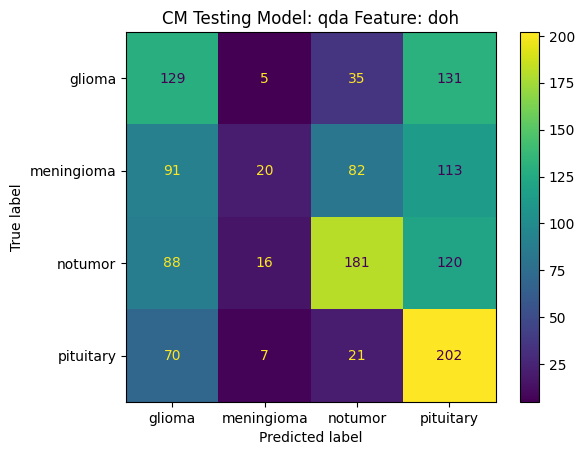

(1311, 4)


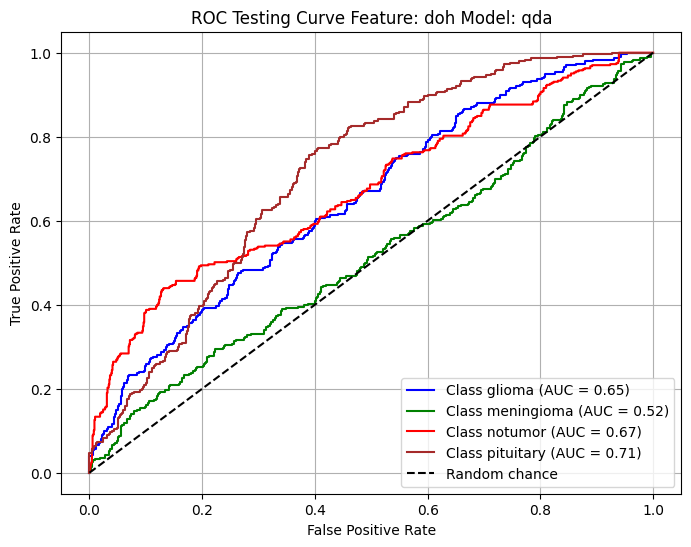

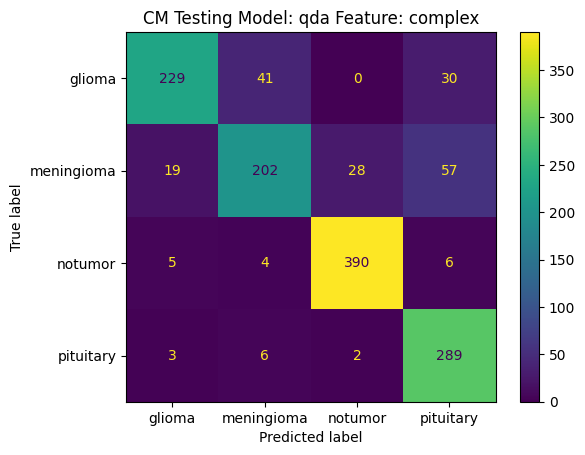

(1311, 4)


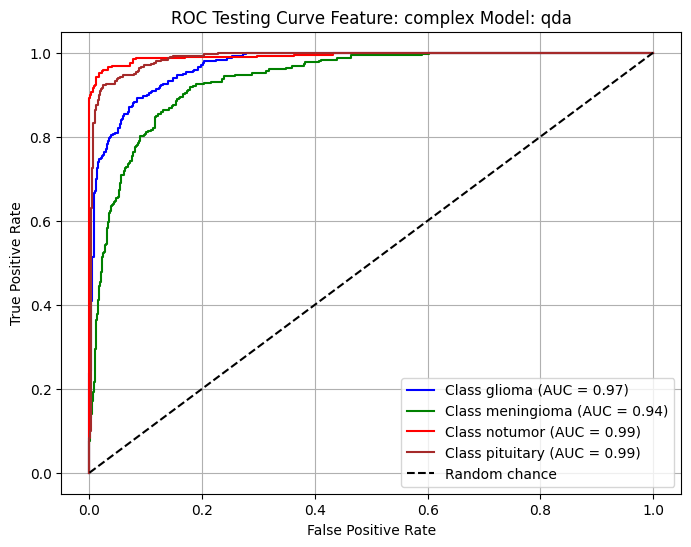

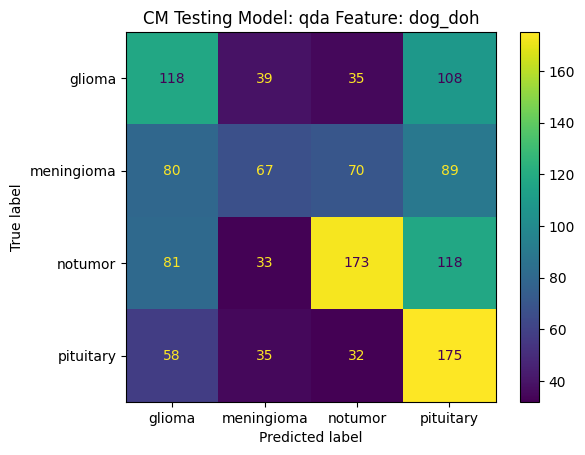

(1311, 4)


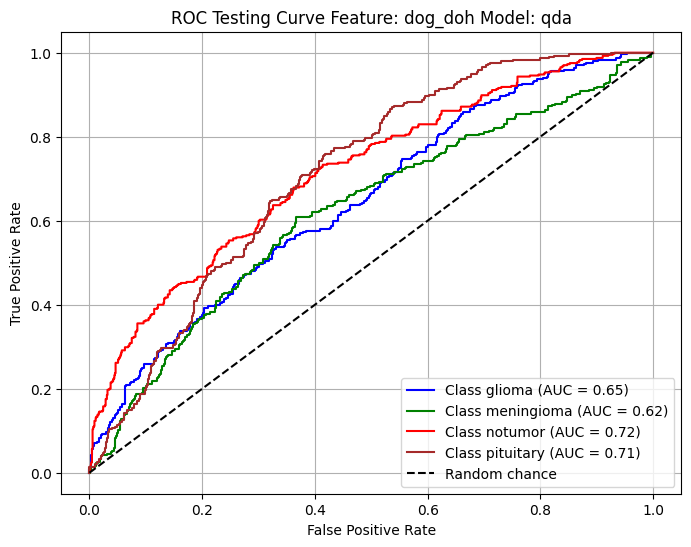

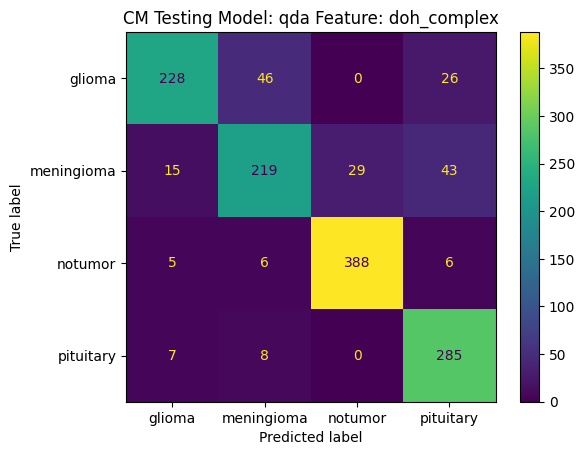

(1311, 4)


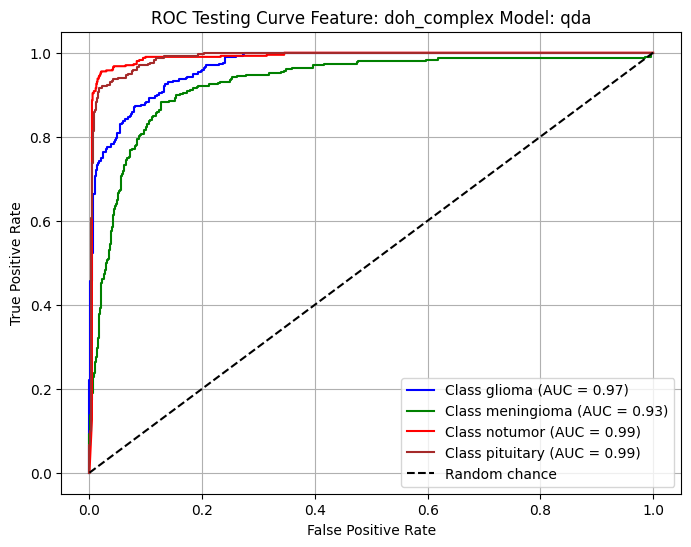

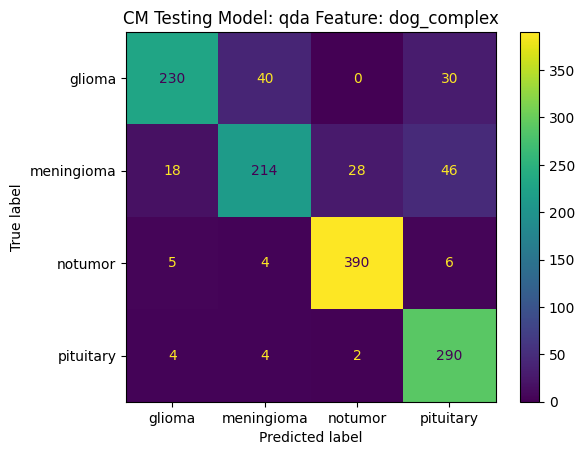

(1311, 4)


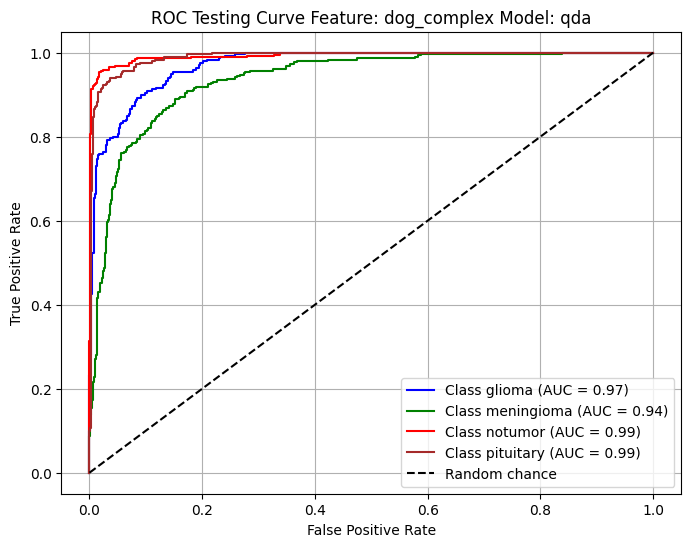

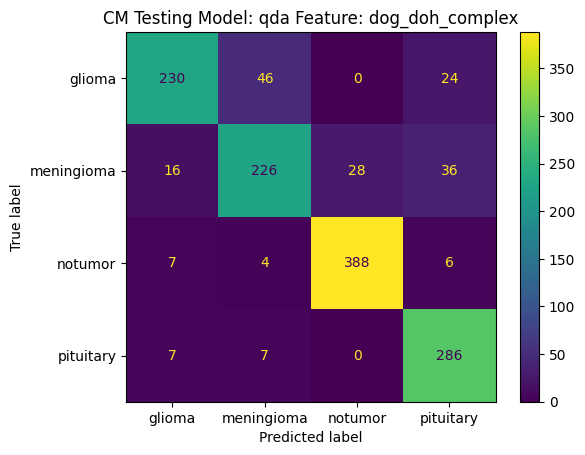

(1311, 4)


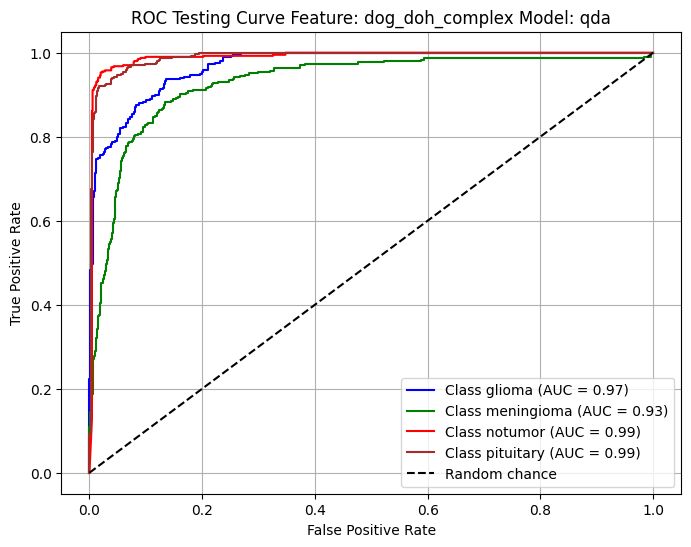

In [91]:
for feature in qda_models.keys():
    results = test_model(qda_models[feature], test_features[feature], y_test, classes=le.classes_, model_type='qda', feature=feature)
    test_results.loc[len(test_results)] = results

In [92]:
test_results

feature model_type  accuracy_score  macro_precision  macro_recall  \
0               dog   logistic        0.431732         0.424052      0.417562   
1               doh   logistic        0.421053         0.394798      0.407262   
2           complex   logistic        0.965675         0.963574      0.962729   
3           dog_doh   logistic        0.502670         0.494962      0.493170   
4       doh_complex   logistic        0.965675         0.963711      0.962712   
5       dog_complex   logistic        0.964150         0.961881      0.961078   
6   dog_doh_complex   logistic        0.963387         0.961343      0.960261   
7               dog         rf        0.513349         0.551843      0.502591   
8               doh         rf        0.556827         0.525848      0.536135   
9           complex         rf        0.761251         0.746609      0.745646   
10          dog_doh         rf        0.602593         0.614586      0.582407   
11      doh_complex         rf        0.762014         0.744166      0.745416   
12      dog_complex         rf        0.774981         0.764671      0.760051   
13  dog_doh_complex         rf        0.760488         0.747441      0.744250   
14              dog        lda        0.476735         0.470108      0.466683   
15              doh        lda        0.450038         0.439726      0.439869   
16          complex        lda        0.944317         0.944228      0.939991   
17          dog_doh        lda        0.536995         0.526057      0.525904   
18      doh_complex        lda        0.942029         0.941812      0.937540   
19      dog_complex        lda        0.946606         0.946273      0.942491   
20  dog_doh_complex        lda        0.941266         0.940918      0.936707   
21              dog        qda        0.318841         0.332644      0.325919   
22              doh        qda        0.405797         0.420556      0.403902   
23          complex        qda        0.846682         0.844517      0.837440   
24          dog_doh        qda        0.406560         0.412603      0.405695   
25      doh_complex        qda        0.854310         0.850297      0.845928   
26      dog_complex        qda        0.857361         0.854969      0.848911   
27  dog_doh_complex        qda        0.861937         0.857099      0.854147   

    macro_f1  micro_precision  micro_recall  micro_f1  inference_time  
0   0.414436         0.431732      0.431732  0.431732        0.006602  
1   0.390968         0.421053      0.421053  0.421053        0.001302  
2   0.962829         0.965675      0.965675  0.965675        0.013793  
3   0.487484         0.502670      0.502670  0.502670        0.001732  
4   0.962833         0.965675      0.965675  0.965675        0.010287  
5   0.961138         0.964150      0.964150  0.964150        0.008627  
6   0.960433         0.963387      0.963387  0.963387        0.010777  
7   0.487973         0.513349      0.513349  0.513349        0.063990  
8   0.504247         0.556827      0.556827  0.556827        0.048375  
9   0.732940         0.761251      0.761251  0.761251        0.111597  
10  0.565092         0.602593      0.602593  0.602593        0.050406  
11  0.732537         0.762014      0.762014  0.762014        0.045659  
12  0.749893         0.774981      0.774981  0.774981        0.073628  
13  0.733621         0.760488      0.760488  0.760488        0.156317  
14  0.461633         0.476735      0.476735  0.476735        0.001884  
15  0.434065         0.450038      0.450038  0.450038        0.001502  
16  0.940959         0.944317      0.944317  0.944317        0.010153  
17  0.519547         0.536995      0.536995  0.536995        0.001659  
18  0.938636         0.942029      0.942029  0.942029        0.015966  
19  0.943339         0.946606      0.946606  0.946606        0.009789  
20  0.937704         0.941266      0.941266  0.941266        0.017564  
21  0.301650         0.318841      0.318841  0.318841        0.004981  
22  0.

In [106]:
test_results.to_csv('test_results.csv')